<a href="https://colab.research.google.com/github/velblu/Tokyo-Stock-Exchange-Predictions/blob/main/jpx_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Task description
This is an attempt to create technical classificator based only on technical values like OHLCV. No fundamental information are taken into consideration (like business sectors or financial results). 

Classificator should point to buy (long position) or do nothing on next day morning (on open). We expect that in next 5 days stock price will go up for 2% or more on close.

Target value is based on next day open value and max from next 5 days close values: (max(next 5 Close) - Open) / Open, if:
- return < 2%     then None
- 2% <= return       then Long

There is a target data in dataset but new target data will be created.

Original data comes from: 
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

# B. Prerequisitions
Importing right packages..

In [4]:
# basics
import pandas
import pandas as pd
import numpy as np
import re
import pickle
# from datetime import datetime

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, \
                            roc_auc_score, f1_score, precision_score, \
                            recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, \
                                    KFold, StratifiedKFold

#xgboost
from xgboost import XGBClassifier

#hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, partial

# drawings
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

.. and downloading dataset

In [5]:
# downloading file with data (was to big for github)
!gdown --id 10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt
To: /content/stock_prices.csv
100% 218M/218M [00:00<00:00, 311MB/s]


# C. Data preparation
In this part data will be loaded and analysed. Transformers will be build and tested.

## 1. Loading dataset 

In [3]:
# preparing function to load dataset
def load_dataset(folder_name: str, file_name: str, index_col: list = None) -> pandas.DataFrame:
    """
    Loading dataset. 

    :param folder_name: Folders path to file with data    
    :param file_name: Name of file 
    :param index_col: List of columns that are indexes
    :return: Dataframe with dataset
    """
    dataset = pd.read_csv(f'{file_name}', index_col=index_col)
    return dataset


In [4]:
FOLDER: str = ''
FILE: str = 'stock_prices.csv'
INDEX: list = []

# Loading dataset with prices and volumes (and other)
data = load_dataset(FOLDER, FILE, INDEX)
data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [5]:
# housekeeping .. 
del FILE
del FOLDER
del INDEX
del STATUS_OK

## 2. Dataset specification
High level analysis to understand the data with little summary on the end. 
But first lets check data types..


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


Looks like most of data are numbers. Only RowId and Date are objects. 

### 2.1 SecuritiesCode 
- description: local securities code
- type: Int64
- sample value: 1301

In [7]:
# description of this data
data['SecuritiesCode'].describe().apply("{0:.1f}".format)

count    2332531.0
mean        5894.8
std         2404.2
min         1301.0
25%         3891.0
50%         6238.0
75%         7965.0
max         9997.0
Name: SecuritiesCode, dtype: object

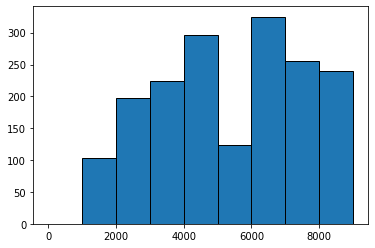

In [8]:
# securieties codes list
securieties_codes: list = list(data['SecuritiesCode'].unique())

plt.hist(securieties_codes, bins=range(0, 10000, 1000), edgecolor='black')
plt.show()

This is a column with securities id's and will be used as index.
- minimal value is 1301
- maximum value is 9997

In [9]:
# setting as index
data.set_index(keys=['SecuritiesCode'], inplace=True)
data.head()

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,,,,,,,,,,,
1301,20170104_1301,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,20170104_1332,2017-01-04,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,20170104_1333,2017-01-04,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,20170104_1376,2017-01-04,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,20170104_1377,2017-01-04,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.2 Date

- description: trade date
- type: date
- sample value: 2017-01-04 0:00:00


In [10]:
# describing column
pd.to_datetime(data['Date']).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                 2332531
unique                   1202
top       2021-12-03 00:00:00
freq                     2000
first     2017-01-04 00:00:00
last      2021-12-03 00:00:00
Name: Date, dtype: object

In [11]:
# checking days of week
pd.to_datetime(data['Date']).dt.day_name().unique()

array(['Wednesday', 'Thursday', 'Friday', 'Tuesday', 'Monday'],
      dtype=object)

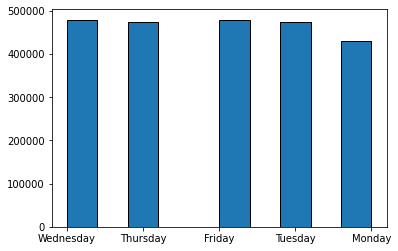

In [12]:
# days of week histogram
plt.hist(pd.to_datetime(data['Date']).dt.day_name(), 
         edgecolor='black')
plt.show()

This is column with trade dates and it will be used as index. 
- Dates starts from 2017-01-04 and finishes at 2021-12-03. 
- Dates are only monday - friday days of week 
- There is even distribution of data by days of week

In [13]:
# setting as index
data.set_index(keys=['Date'], append=True, inplace=True)
data.head()

,,RowId,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,Date,,,,,,,,,,
1301,2017-01-04,20170104_1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,2017-01-04,20170104_1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,2017-01-04,20170104_1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,2017-01-04,20170104_1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,2017-01-04,20170104_1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.3 RowID
- description: unique ID of price records
- type: string 
- sample value: 20170104_1301

In [14]:
# description of this data
data['RowId'].describe()

count           2332531
unique          2332531
top       20170104_1301
freq                  1
Name: RowId, dtype: object

In [15]:
# counting nulls 
data['RowId'].isnull().sum()

0

In [16]:
# how does structure of row id looks like? 
data['RowId'][:10]

SecuritiesCode  Date      
1301            2017-01-04    20170104_1301
1332            2017-01-04    20170104_1332
1333            2017-01-04    20170104_1333
1376            2017-01-04    20170104_1376
1377            2017-01-04    20170104_1377
1379            2017-01-04    20170104_1379
1381            2017-01-04    20170104_1381
1407            2017-01-04    20170104_1407
1414            2017-01-04    20170104_1414
1417            2017-01-04    20170104_1417
Name: RowId, dtype: object

This is column is an id for a row and brings no value for us. Will be deleted
- one row id occurs only ones
- there are no null values
- structure of this data: YYYYMMDD_SecurietiesCode

In [17]:
# adding to remove 
prepering_data_remove_columns: list = ['RowId']

### 2.4 OHLC

Open:
- description: first traded price on a day
- type: float
- sample value: 2734

High:
- description: highest traded price on a day
- type: float
- sample value: 2755

Low: 
- description: lowest traded price on a day
- type: float
- sample value: 2730

Close:
- description: last traded price on a day
- type: float
- sample value: 2742

In [18]:
# description of this data
data[['Open', 'High', 'Low', 'Close']].describe().applymap("{0:.1f}".format)

,Open,High,Low,Close
count,2324923.0,2324923.0,2324923.0,2324923.0
mean,2594.5,2626.5,2561.2,2594.0
std,3577.2,3619.4,3533.5,3576.5
min,14.0,15.0,13.0,14.0
25%,1022.0,1035.0,1009.0,1022.0
50%,1812.0,1834.0,1790.0,1811.0
75%,3030.0,3070.0,2995.0,3030.0
max,109950.0,110500.0,107200.0,109550.0


In [19]:
# securieties codes list cut to first ten securieties
securieties_codes_head: list = securieties_codes[:10]

fig = go.Figure()

# creating traces for figure - candelstick figures for selected securieties
for securities_code in securieties_codes_head:
  fig.add_trace(
      go.Candlestick(x=data.loc[securities_code].index,
                     open=data.loc[securities_code]['Open'],
                     high=data.loc[securities_code]['High'],
                     low=data.loc[securities_code]['Low'],
                     close=data.loc[securities_code]['Close'])
  )

button_all: list = [dict(label = f'All_{len(securieties_codes_head)}',
                  method = 'update',
                  args = [{'visible': [True for sec_code in securieties_codes_head],
                            'title': 'All',
                            'showlegend':False}]),]

def create_securieties_button(securieties_code: int) -> dict:
  """
  Creates single button description for securieties menu.
  
  :param X: Securieties code
  :return: Single button description
  :
  """
  return dict(label=str(securieties_code),
              method='update',
              args=[{'visible': [sec_code == securieties_code 
                                 for sec_code in securieties_codes_head],
                     'title': str(securieties_code),
                     'showlegend': False}])

# buttons list (with 'all values' button)
buttons: list  = [create_securieties_button(sec_code) 
                    for sec_code in securieties_codes_head]
all_buttons: list = button_all + buttons

# adding menu to plot
fig.update_layout(title='Selected securieties codes charts',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons= all_buttons
)])

fig.show()

In [20]:
# checking if nulls in OHLC occurs always in all OHLC at ones

# df with rowids
ohlc_nulls = data['RowId'].to_frame()

# how many rows with null values in all OHLC at ones
ohlc_nulls['all'] = data[['Open', 'High', 'Low', 'Close']].isna().all(axis=1)

# how many rows where null values is in only one OHLC
ohlc_nulls['any'] = data[['Open', 'High', 'Low', 'Close']].isna().any(axis=1)

# for which RowIds nulls in any of OHLC do not overlap nulls witk all of OHLC
ohlc_nulls['RowId'][ohlc_nulls['any'] != ohlc_nulls['all']]
# there are non that kind of rows

Series([], Name: RowId, dtype: object)

In [21]:
# dates were all securieties do not have OHLC values 
# series of dates where all securieties count == securieties with all nulls in OHLC
ohlc_nulls_all=ohlc_nulls['RowId'].groupby(['Date']).count() == ohlc_nulls['all'].groupby(['Date']).sum()

# dates where this occured
ohlc_nulls_all[ohlc_nulls_all]

#there were only one date like that
# https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html

Date
2020-10-01    True
dtype: bool

This columns are main information for our analysis. Rows with null should be removed.
- representing stock values in day period 
- are variety of float values 
- in time dimension creates stock chart 
- null values occur only for all OHLC values at once 
- one day (2020-10-01 ) jpx was off https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html 

### 2.5 Volume 
- description: number of traded stocks on a day
- type: Int64
- sample value: 31400

In [22]:
# description of this data
data['Volume'].describe().apply("{0:.1f}".format)

count      2332531.0
mean        691936.6
std        3911255.9
min              0.0
25%          30300.0
50%         107100.0
75%         402100.0
max      643654000.0
Name: Volume, dtype: object

In [23]:
# how many null values
data['Volume'].isna().sum()

0

In [24]:
# when null values occur
ohlc_nulls['volume'] = data['Volume'] == 0

# checking if ohlc is null then volume != 0 ? 
ohlc_nulls['RowId'][ohlc_nulls['all'] != ohlc_nulls['volume']]

# in all row_ids (data-securieties): 
# when OHLC is null =>  volume == 0 
# or 
# when OHLC is not null => volume != 0

Series([], Name: RowId, dtype: object)

This column gives main information for our analysis as well. Rows should be removed when OHLC values are nulls.
- there is variety of values in this column
- there are no null values
- when all OHLC are null => volume == 0 
- when OHLC values are not null => volume > 0


### 2.6 AdjustmentFactor
- description: to calculate theoretical price/volume when split reverse-split happens (NOT including dividend/allotment of shares/)
- type: float
- sample value: 1

In [25]:
# how many different values?
data['AdjustmentFactor'].value_counts(dropna=False)

1.000000     2331801
0.500000         328
5.000000         113
10.000000        103
0.333333          59
2.000000          36
0.250000          33
0.200000          20
0.909091          10
0.833333           6
0.769231           6
0.666667           4
0.100000           3
0.952381           3
0.800000           2
0.142857           1
0.869565           1
4.000000           1
20.000000          1
Name: AdjustmentFactor, dtype: int64

In [26]:
# number of rows where no merge/split were done
data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count()
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 2331801
%: 99.96870352419754


In [27]:
# how many merge actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 254
%: 0.01088945870387146


In [28]:
# how many split actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 476
%: 0.020407017098593758


It will not influence our analysis because we are analysing only difference between Open and Close value in this same day. Will information that split/merge happen be useful? I think not.
- there are no nulls 
- there where 476 splits (0,02% of all)
- there where 254 merges (0,01% of all) 

### 2.7 SupervisionFlag 
- description: "Flag of Securities Under Supervision & Securities to Be Delisted
https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )"
- type: boolean
- sample value: FALSE



In [29]:
# how many null values?
data['SupervisionFlag'].isnull().sum()

0

In [30]:
# number of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=False)

False    2332001
True         530
Name: SupervisionFlag, dtype: int64

In [31]:
# percentage of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=True)

False    0.999773
True     0.000227
Name: SupervisionFlag, dtype: float64

Low number of situations where stocks where under supervisioning. This information will not be usefull.
- there are no nulls 
- there where 530 cases like that (0,02% of all) 
- need to be changed to categorical type

### 2.8 ExpectedDividend 
- description: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
- type: float
- sample value:

In [32]:
# number of rows
data['ExpectedDividend'].value_counts(dropna=False, normalize=False)

NaN       2313666
0.00         3551
10.00         901
20.00         838
15.00         797
           ...   
18.80           1
26.22           1
325.00          1
56.60           1
16.37           1
Name: ExpectedDividend, Length: 447, dtype: int64

In [33]:
# number of cases like that
data['ExpectedDividend'].count()

18865

This columns is mostly nulls but it can be useful in this attempt. 

### 2.9 Target 
- description: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate
- type: float
- sample value: 0.00073

New target column will have to be created. This one is inconsistent with the goals of our attempt. 

In [34]:
# adding to delete
prepering_data_remove_columns.append('Target')
prepering_data_remove_columns

['RowId', 'Target']

### 2.10 Housekeeping.. 

In [35]:
del all_buttons, button_all, buttons
del fig
del ohlc_nulls, ohlc_nulls_all
del securieties_codes, securieties_codes_head, securities_code

## 3. Transformers for data preparation
Building and testing transformers for data preparation section. 

In [36]:
# copying data for testing purposes
test_data = data.copy()

### 3.1 DeleteRowsWithNulls 

In [37]:
class DeleteRowsWithNulls(BaseEstimator, TransformerMixin):
    """
    Transformer removing rows with null values (all/any) in specified columns.

    :param subset: List of columns where null values will be searched for, if None then all columns will be used.
    :param how: Determine if row or column is removed from DataFrame, when we have at least one NA or all NA.
    """
    how: str
    subset: list

    def __init__(self, subset: list = None, how: str = 'all'):
        self.subset = subset
        self.how = how

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Set which column should be considered if None was given. 
        And then remove rows with nulls.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Transformed input (with deleted rows).
        """
        if self.subset is None:
            self.subset = X.columns.tolist()
        return X.dropna(subset=self.subset, how=self.how)

In [38]:
# removing rows where all OHLC values are nulls 
test_transformer = DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.isna().sum()

RowId                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2306082
SupervisionFlag           0
Target                    0
dtype: int64

### 3.2 SortData

In [39]:
class SortData(BaseEstimator, TransformerMixin):
    """
    Transformer which sort data by columns (ascending).

    :param by: List of columns by which sorting is done
    :param axis: Axis to be sorted.
    """
    by: list
    axis: str

    def __init__(self, by: list = None, axis: str = 'index'):
        self.by = by
        self.axis = axis

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """

        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Set by which names sorting will be done if None were given in params.
        And then sort data by names

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Sorted input.
        """
        if self.by is None:
            self.by = list(X.index.names)
        return X.sort_values(by=self.by, axis=self.axis, ascending=True, inplace=False)

In [40]:
# sorting data by index
test_transformer = SortData(by=['SecuritiesCode', 'Date'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target  
SecuritiesCode Date                                   
1301           2017-01-04            False  0.000730  
               2017-01-05            False  0.002920  
               2017-01-06            False -0.001092  
               2017-01-10            False -0.005100  
               2017-01-11            False -0.003295  
...                                    ...       ...  
9997           2021-11-29            False  0.026987  
               2021-11-30            False -0.001460  
               2021-12-01            False  0.017544  
               2021-12-02            False  0.014368  
               2021-12-03            False  0.018414  

[2324923 rows x 10 columns]

### 3.3 AddNewClassification

In [41]:
class AddNewClassification(BaseEstimator, TransformerMixin):
    """
    Transformer which adds new target data (as column) based on next day Open 
    and next 5 days Close values.

    * result < 0.02    => None
    * 0.02 <= result   => Long
    """
    new_col_name: str

    def __init__(self, new_col_name='Class'):

        self.new_col_name = new_col_name

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating and categorizing new target values.
        And then adding column with new classificator.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with new classificator as new column.
        """

        def categorize_result(result) -> int:
            """
            Change numerical value to categorical value.

            :param result: Numerical value for new target
            :return: Categorical value for new target
            """
            if result < 0.02:
                return 'None'
            else:
                return 'Long'

        # take only open and close values
        df = X[['Close', 'Open']].copy()

        # max close value from next 5 days (without today)
        # reverse order and grouped 
        # without today 
        # max value from next 5 days 
        df['close_max5'] = df[::-1].groupby('SecuritiesCode') \
                                   .shift(1) \
                                   .rolling(5)['Close'] \
                                   .max() 

        # next day open value
        df['open1'] = df['Open'].shift(-1)
        df['result'] = (df['close_max5'] - df['open1']) / df['open1']

        # print(df)

        new_target = (df['close_max5'] - df['open1']) / df['open1']

        # self.new_target = self.new_target.apply(categorize_result).groupby('SecuritiesCode').shift(-1).astype('category')
        new_target = new_target.apply(categorize_result).astype('category')
        new_target.rename('Class', inplace=True)

        X_out: pandas.DataFrame = X.copy()
        return X_out.join(new_target)

In [42]:
# creating new classification 
test_transformer = AddNewClassification()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target Class  
SecuritiesCode Date                                         
1301           2017-01-04            False  0.000730  None  
               2017-01-05            False  0.002920  None  
               2017-01-06            False -0.001092  None  
               2017-01-10            False -0.005100  None  
               2017-01-11            False -0.003295  None  
...                                    ...       ...   ...  
9997           2021-11-29            False  0.026987  Long  
               2021-11-30            False -0.001460  Long  
               2021-12-01            False  0.017544  Long  
               2021-12-02            False  0.014368  Long  
               2021-12-03            False  0.018414  Long  

[2324923 rows x 11 columns]

In [43]:
test_data['Class'].value_counts()

None    1366986
Long     957937
Name: Class, dtype: int64

### 3.4 DropColumns

In [44]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    cols_to_drop: list

    def __init__(self, cols_to_drop: list = None):
        self.cols_to_drop = cols_to_drop

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Dropping columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        if self.cols_to_drop is None:
            self.cols_to_drop = []
        
        return X.drop(labels=self.cols_to_drop,
                      axis=1,
                      inplace=False)

In [45]:
test_transformer = DropColumns(cols_to_drop=['RowId', 'Target'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   bool    
 8   Class             category
dtypes: bool(1), category(1), float64(6), int64(1)
memory usage: 202.1+ MB


### 3.5 ColumnTypeChanger

In [46]:
class ColumnTypeChanger(BaseEstimator, TransformerMixin):
    """
    Transformer which change type of columns.
    """
    col: list
    to_type: str

    def __init__(self, col: str = None, to_type: str = None):
        self.col = col
        self.to_type = to_type

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Changing column type.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if (self.to_type is None) or (self.col is None):
            return X
        else:
            X_out = X.copy()
            X_out[self.col] = X_out[self.col].astype(self.to_type)
            return X_out

In [47]:
test_transformer = ColumnTypeChanger(col='SupervisionFlag', to_type='category')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   category
 8   Class             category
dtypes: category(2), float64(6), int64(1)
memory usage: 202.1+ MB


### 3.6 PreviousPeriodsJoiner

In [48]:
class PreviousPeriodsJoiner(BaseEstimator, TransformerMixin):
    """

    Transformer which adds ohlcv data from previous periods. 

    :param periods_num: number of previous periods to add to the set
    :param ohlcv_col: OHLCV choice to add
    """
    periods_num: int
    ohlcv_col: str

    def __init__(self, periods_num: int = 30, ohlcv_col: str = 'Close'):
        self.periods_num = periods_num
        self.ohlcv_col = ohlcv_col

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding values from previous periods.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if self.periods_num > 0: 
          X_out = X.copy()

          #index of a ohlcv column
          index_no = X_out.columns.get_loc(self.ohlcv_col) 
          
          for period_num in range(self.periods_num, -1, -1):
            # name of new column
            col_name = self.ohlcv_col + '-' + str(period_num) 
            # values of new column
            col_to_add = X_out \
                  .groupby('SecuritiesCode')[self.ohlcv_col] \
                  .shift(period_num)
            # inserting new column                  
            X_out.insert(index_no, col_name, col_to_add)

            index_no += 1 # index for next new column has to change by 1
          
          return X_out    
        
        else:
          return X           

In [49]:
test_transformer = PreviousPeriodsJoiner(periods_num=5, ohlcv_col='High')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
print(test_data.info())
print(test_data[['High-5', 'High-4', 'High-3', 'High-2','High-1','High-0', 'High']].loc[1301])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 15 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High-5            float64 
 2   High-4            float64 
 3   High-3            float64 
 4   High-2            float64 
 5   High-1            float64 
 6   High-0            float64 
 7   High              float64 
 8   Low               float64 
 9   Close             float64 
 10  Volume            int64   
 11  AdjustmentFactor  float64 
 12  ExpectedDividend  float64 
 13  SupervisionFlag   category
 14  Class             category
dtypes: category(2), float64(12), int64(1)
memory usage: 308.5+ MB
None
            High-5  High-4  High-3  High-2  High-1  High-0    High
Date                                                              
2017-01-04     NaN     NaN     NaN     NaN     NaN  2755.0  2755.0
2017-01-05     NaN     NaN     NaN    

### 3.7 ResetIndex

In [50]:
class ResetIndex(BaseEstimator, TransformerMixin):
    """
    Reset (drop) dataframe index.
    """

    def __init__(self):
        pass

    def fit(self, X=None, y=None):
        """
        Doing nothing.

        :param X: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Droping index of dataframe

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        return X_out.reset_index(drop=True)

In [51]:
# removing index
test_transformer = ResetIndex()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

,Open,High-5,High-4,High-3,High-2,High-1,High-0,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Class
0,2734.0,NaN,NaN,NaN,NaN,NaN,2755.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,None
1,2743.0,NaN,NaN,NaN,NaN,2755.0,2747.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,None
2,2734.0,NaN,NaN,NaN,2755.0,2747.0,2744.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,None
3,2745.0,NaN,NaN,2755.0,2747.0,2744.0,2754.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,None
4,2748.0,NaN,2755.0,2747.0,2744.0,2754.0,2752.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,678.0,722.0,717.0,719.0,711.0,702.0,679.0,679.0,665.0,668.0,320800,1.0,NaN,False,Long
2324919,670.0,717.0,719.0,711.0,702.0,679.0,689.0,689.0,667.0,667.0,296300,1.0,NaN,False,Long
2324920,661.0,719.0,711.0,702.0,679.0,689.0,688.0,688.0,660.0,685.0,339100,1.0,NaN,False,Long
2324921,681.0,711.0,702.0,679.0,689.0,688.0,692.0,692.0,680.0,684.0,342900,1.0,NaN,False,Long


### 3.8 SimpleImputerWrapper

In [52]:
class SimpleImputerWrapper(BaseEstimator, TransformerMixin):
    """
    Wrapper for SimpleImputer to work on selected columns and return DataFrame.

    :param cols: list of columns to change.
    :param strategy: The imputation strategy.
    """
    cols: list
    imputer: SimpleImputer

    def __init__(self, cols: list=None, strategy: str='constant'):
        self.cols = cols
        self.imputer = SimpleImputer(strategy=strategy)

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Fitting if columns list is not empty

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.cols is None:
          return self
        else:
          self.imputer.fit(X[self.cols])
          return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Transforming selected columns, in columns list is empty then doing nothing.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if self.cols is None:
          return X
        else:
          X_out = X.copy()
          # cols that should be changed - double check if cols have proper names
          self.cols = [element for element in X_out.columns.tolist() 
                          if element in self.cols]
          
          # cols that should not be changed
          rest_of_cols = [element for element in X_out.columns.tolist() 
                          if not element in self.cols]

          # transforming only selected columns 
          transformed_data = self.imputer.transform(X_out[self.cols])

          # and going back to df with proper namescols names
          transformed_data = pd.DataFrame(transformed_data, 
                                          columns=self.cols, 
                                          index=X_out.index)
          # merging X_out: 
          X_out = X_out[rest_of_cols]
          X_out = X_out.join(transformed_data)
          return X_out           

In [53]:
test_data[['ExpectedDividend']].value_counts(dropna=False)
# should be 2,309,622 of values 0 after tranformation 
# it's 2,306,082 of NaN and 3,540 of 0.00

ExpectedDividend
NaN                 2306082
0.00                   3540
10.00                   900
20.00                   837
15.00                   797
                     ...   
18.80                     1
18.36                     1
17.60                     1
17.30                     1
28.99                     1
Length: 447, dtype: int64

In [54]:
test_transformer = SimpleImputerWrapper(cols=['ExpectedDividend'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

,Open,High-5,High-4,High-3,High-2,High-1,High-0,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Class,ExpectedDividend
0,2734.0,NaN,NaN,NaN,NaN,NaN,2755.0,2755.0,2730.0,2742.0,31400,1.0,False,None,0.0
1,2743.0,NaN,NaN,NaN,NaN,2755.0,2747.0,2747.0,2735.0,2738.0,17900,1.0,False,None,0.0
2,2734.0,NaN,NaN,NaN,2755.0,2747.0,2744.0,2744.0,2720.0,2740.0,19900,1.0,False,None,0.0
3,2745.0,NaN,NaN,2755.0,2747.0,2744.0,2754.0,2754.0,2735.0,2748.0,24200,1.0,False,None,0.0
4,2748.0,NaN,2755.0,2747.0,2744.0,2754.0,2752.0,2752.0,2737.0,2745.0,9300,1.0,False,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,678.0,722.0,717.0,719.0,711.0,702.0,679.0,679.0,665.0,668.0,320800,1.0,False,Long,0.0
2324919,670.0,717.0,719.0,711.0,702.0,679.0,689.0,689.0,667.0,667.0,296300,1.0,False,Long,0.0
2324920,661.0,719.0,711.0,702.0,679.0,689.0,688.0,688.0,660.0,685.0,339100,1.0,False,Long,0.0
2324921,681.0,711.0,702.0,679.0,689.0,688.0,692.0,692.0,680.0,684.0,342900,1.0,False,Long,0.0


In [55]:
test_data[['ExpectedDividend']].value_counts(dropna=False)
# there's 2,309,622 of 0.0 values and that's correct

ExpectedDividend
0.00                2309622
10.00                   900
20.00                   837
15.00                   797
25.00                   789
                     ...   
18.36                     1
17.60                     1
17.30                     1
17.25                     1
1070.00                   1
Length: 446, dtype: int64

### 3.9 Housekeeping..

In [56]:
del test_data
del test_transformer

## 4. Pipeline for data preparation
Let's build a pipeline :)

In [57]:
# data preparation pipeline
data_preparation_pipeline = Pipeline(steps=[
    ('removing_null_values', DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')),
    ('sort_dataset', SortData(by=['SecuritiesCode', 'Date'])),
    ('change_supervisionflag_type', ColumnTypeChanger(col='SupervisionFlag', to_type='category')),
    ('add_new_target', AddNewClassification()),
    ('drop_columns', DropColumns(cols_to_drop=['RowId', 'Target'])),
    ('add_prev_high', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='High')),
    ('add_prev_low', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Low')),
    ('add_prev_open', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Open')),
    ('add_prev_close', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Close')),
    ('add_prev_volume', PreviousPeriodsJoiner(periods_num=30, ohlcv_col='Volume')),
    ('change_nan_in_dividend', SimpleImputerWrapper(cols=['ExpectedDividend'])),
    ('drop_nulls', DeleteRowsWithNulls(how='any')),
    ('drop_index', ResetIndex())
])

In [58]:
%%time
# .. and testing.. 
data = data_preparation_pipeline.fit_transform(X=data)
data.head()

CPU times: user 30.2 s, sys: 4.67 s, total: 34.8 s
Wall time: 34.6 s


,Open-30,Open-29,Open-28,Open-27,Open-26,Open-25,Open-24,Open-23,Open-22,Open-21,...,Volume-4,Volume-3,Volume-2,Volume-1,Volume-0,Volume,AdjustmentFactor,SupervisionFlag,Class,ExpectedDividend
0,2734.0,2743.0,2734.0,2745.0,2748.0,2745.0,2707.0,2725.0,2702.0,2689.0,...,28400.0,35900.0,47200.0,34600.0,27700,27700,1.0,False,Long,0.0
1,2743.0,2734.0,2745.0,2748.0,2745.0,2707.0,2725.0,2702.0,2689.0,2694.0,...,35900.0,47200.0,34600.0,27700.0,26600,26600,1.0,False,Long,0.0
2,2734.0,2745.0,2748.0,2745.0,2707.0,2725.0,2702.0,2689.0,2694.0,2724.0,...,47200.0,34600.0,27700.0,26600.0,35700,35700,1.0,False,Long,0.0
3,2745.0,2748.0,2745.0,2707.0,2725.0,2702.0,2689.0,2694.0,2724.0,2730.0,...,34600.0,27700.0,26600.0,35700.0,35900,35900,1.0,False,Long,0.0
4,2748.0,2745.0,2707.0,2725.0,2702.0,2689.0,2694.0,2724.0,2730.0,2718.0,...,27700.0,26600.0,35700.0,35900.0,54500,54500,1.0,False,Long,0.0


In [59]:
# checking columns name on 'High' example
[column for column in data.columns if column.find('High')!=-1]

['High-30',
 'High-29',
 'High-28',
 'High-27',
 'High-26',
 'High-25',
 'High-24',
 'High-23',
 'High-22',
 'High-21',
 'High-20',
 'High-19',
 'High-18',
 'High-17',
 'High-16',
 'High-15',
 'High-14',
 'High-13',
 'High-12',
 'High-11',
 'High-10',
 'High-9',
 'High-8',
 'High-7',
 'High-6',
 'High-5',
 'High-4',
 'High-3',
 'High-2',
 'High-1',
 'High-0',
 'High']

In [60]:
# checking values for 'High'
# remember that all rows with any null value in is columns were deleted
# and that index was dropped
data[[column for column in data.columns if column.find('High')!=-1]].head()

,High-30,High-29,High-28,High-27,High-26,High-25,High-24,High-23,High-22,High-21,...,High-8,High-7,High-6,High-5,High-4,High-3,High-2,High-1,High-0,High
0,2755.0,2747.0,2744.0,2754.0,2752.0,2747.0,2730.0,2725.0,2704.0,2695.0,...,2735.0,2736.0,2737.0,2747.0,2750.0,2789.0,2818.0,2826.0,2841.0,2841.0
1,2747.0,2744.0,2754.0,2752.0,2747.0,2730.0,2725.0,2704.0,2695.0,2717.0,...,2736.0,2737.0,2747.0,2750.0,2789.0,2818.0,2826.0,2841.0,2833.0,2833.0
2,2744.0,2754.0,2752.0,2747.0,2730.0,2725.0,2704.0,2695.0,2717.0,2737.0,...,2737.0,2747.0,2750.0,2789.0,2818.0,2826.0,2841.0,2833.0,2855.0,2855.0
3,2754.0,2752.0,2747.0,2730.0,2725.0,2704.0,2695.0,2717.0,2737.0,2731.0,...,2747.0,2750.0,2789.0,2818.0,2826.0,2841.0,2833.0,2855.0,2883.0,2883.0
4,2752.0,2747.0,2730.0,2725.0,2704.0,2695.0,2717.0,2737.0,2731.0,2728.0,...,2750.0,2789.0,2818.0,2826.0,2841.0,2833.0,2855.0,2883.0,2937.0,2937.0


In [61]:
# housekeeping .. 
del data_preparation_pipeline
del prepering_data_remove_columns

## 5. Corelations 
Checking corelations between data. 
First we have to get rid of null values on test_data. In main pipeline it will be done differently. 

In [62]:
# new dataset for corr
corr_data = data.copy()

In [63]:
# check nulls
corr_data.isna().sum()

Open-30             0
Open-29             0
Open-28             0
Open-27             0
Open-26             0
                   ..
Volume              0
AdjustmentFactor    0
SupervisionFlag     0
Class               0
ExpectedDividend    0
Length: 164, dtype: int64

In [64]:
# for expected dividend column nulls will be changed to zeros 
corr_data['ExpectedDividend'] = corr_data['ExpectedDividend'].fillna(0)

In [65]:
# now i will prepare 5 lists of columns that were added for calculation purposes 
# (columns for data: Open, Close, High, Low and Volume)

ohlcv_cols_to_drop: dict = {}

for ohlcv_col in ['Open', 'High', 'Low', 'Close', 'Volume']:
  ohlcv_cols_to_drop[ohlcv_col] = [column for column in corr_data.columns 
                if re.search(r''+re.escape(ohlcv_col)+'-', column) is not None]

In [66]:
# dropping added columns with historical OHLCV
for key in ohlcv_cols_to_drop.keys():
  print(key,': ', ohlcv_cols_to_drop.get(key), sep='')
  test_transformer = DropColumns(cols_to_drop=ohlcv_cols_to_drop.get(key))
  test_transformer = test_transformer.fit(X=corr_data)
  corr_data = test_transformer.transform(X=corr_data)

corr_data.columns

Open: ['Open-30', 'Open-29', 'Open-28', 'Open-27', 'Open-26', 'Open-25', 'Open-24', 'Open-23', 'Open-22', 'Open-21', 'Open-20', 'Open-19', 'Open-18', 'Open-17', 'Open-16', 'Open-15', 'Open-14', 'Open-13', 'Open-12', 'Open-11', 'Open-10', 'Open-9', 'Open-8', 'Open-7', 'Open-6', 'Open-5', 'Open-4', 'Open-3', 'Open-2', 'Open-1', 'Open-0']
High: ['High-30', 'High-29', 'High-28', 'High-27', 'High-26', 'High-25', 'High-24', 'High-23', 'High-22', 'High-21', 'High-20', 'High-19', 'High-18', 'High-17', 'High-16', 'High-15', 'High-14', 'High-13', 'High-12', 'High-11', 'High-10', 'High-9', 'High-8', 'High-7', 'High-6', 'High-5', 'High-4', 'High-3', 'High-2', 'High-1', 'High-0']
Low: ['Low-30', 'Low-29', 'Low-28', 'Low-27', 'Low-26', 'Low-25', 'Low-24', 'Low-23', 'Low-22', 'Low-21', 'Low-20', 'Low-19', 'Low-18', 'Low-17', 'Low-16', 'Low-15', 'Low-14', 'Low-13', 'Low-12', 'Low-11', 'Low-10', 'Low-9', 'Low-8', 'Low-7', 'Low-6', 'Low-5', 'Low-4', 'Low-3', 'Low-2', 'Low-1', 'Low-0']
Close: ['Close-30'

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor',
       'SupervisionFlag', 'Class', 'ExpectedDividend'],
      dtype='object')

In [67]:
# for class column rows with nulls will be deleted
test_transformer = DeleteRowsWithNulls(subset=['Class'], how='any')
test_transformer = test_transformer.fit(X=corr_data)
corr_data = test_transformer.transform(X=corr_data)
corr_data.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
SupervisionFlag     0
Class               0
ExpectedDividend    0
dtype: int64

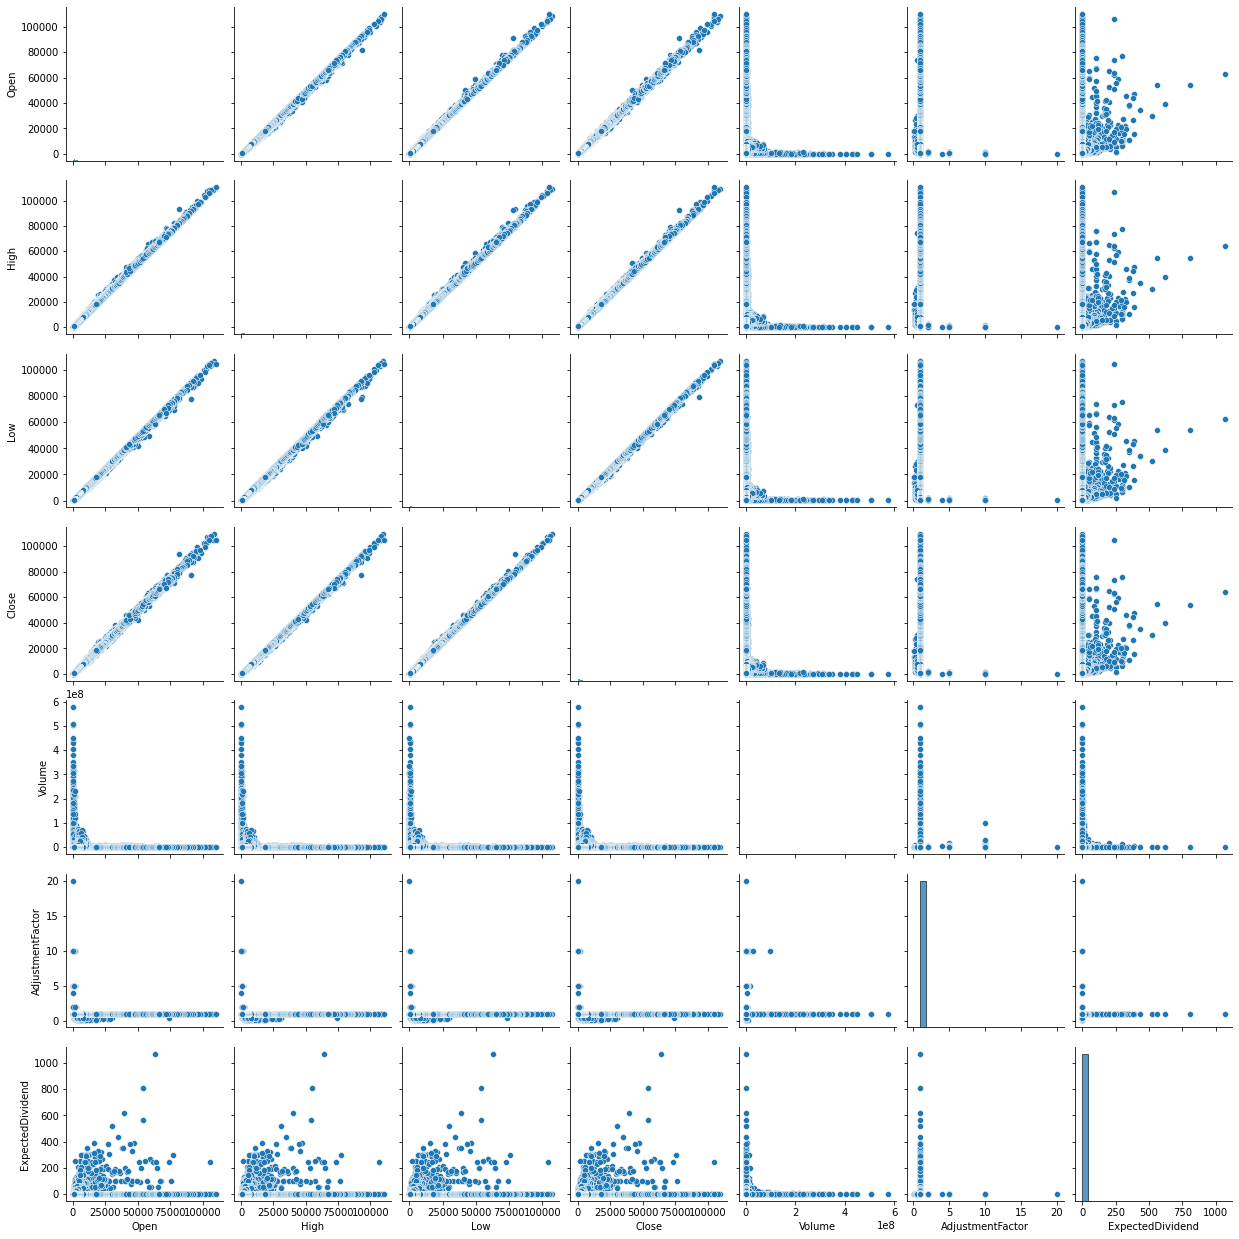

In [68]:
# Corelation as a pair of coordinates
# turned off - long time to compute.. 
sns.pairplot(corr_data)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



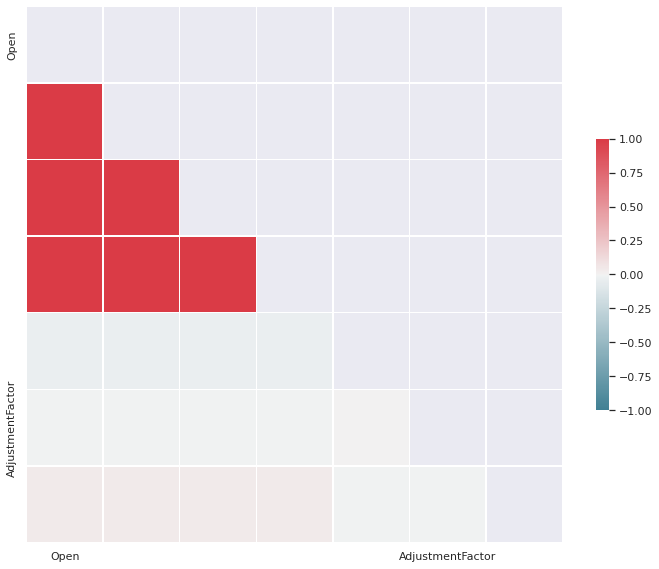

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend
Open,1.000000,0.999856,0.999862,0.999741,-0.036457,-0.006912,0.042142
High,0.999856,1.000000,0.999770,0.999866,-0.036256,-0.006928,0.042064
Low,0.999862,0.999770,1.000000,0.999866,-0.036567,-0.006887,0.042234
Close,0.999741,0.999866,0.999866,1.000000,-0.036406,-0.006902,0.042250
Volume,-0.036457,-0.036256,-0.036567,-0.036406,1.000000,0.005550,-0.000409
AdjustmentFactor,-0.006912,-0.006928,-0.006887,-0.006902,0.005550,1.000000,-0.000410
ExpectedDividend,0.042142,0.042064,0.042234,0.042250,-0.000409,-0.000410,1.000000


In [69]:
sns.set(style="darkgrid")

corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220., 10., as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr

It's not a big supprise that OHLC values are highly correlated with each other. Values are simillar. 

Rest of the dataset do not show correlation. 

In [70]:
# housekeeping.. 
del ax, cmap, corr, corr_data, f, key, mask
del ohlcv_col, ohlcv_cols_to_drop, test_transformer

## 6. Dataset splitting
Last part of dataset preparation. What's in menu? 
*   splitting for X and y
*   splitting for train and test




### 6.1 X/y splitting
First let's split dataset for X and y

In [71]:
# data is now X_data
X_data = data

# and splitting it for X and y
y_data = X_data.pop(item='Class')

### 6.2 Train / test splitting 
Next let's split dataset for train and test..

In [72]:
# podział na test / train
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.20,
                                                    stratify=y_data,
                                                    random_state=42
                                                    )

### 6.3 Housekeeping.. 
Cleaning memory from unnecessary data..

In [73]:
del data
del X_data, y_data

# D. Feature Engineering 
Adding new features.. I will build transformers and deal with train data (fit+transform). Next i will tranform test data (no fitting will be done). 

## 1. Transformers 
Creating tranformers for feature engineering pipeline.

In [74]:
# but first lets prepare test dataset (test only for feature engineering)..
test_data = X_train.loc[[1301, 9997]].copy()

### 1.1 AddDividendInfo



In [75]:
class AddDividendInfo(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) that next day will be a dividend day.
    """

    def __init__(self):
      pass

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Prepare new column with dividend as True/False column.
        And then adding new column with next day dividend as True/False column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """
        X_out: pandas.DataFrame = X.copy()

        dividend_info = pd.Series(None, dtype='bool')
        dividend_info = X_out['ExpectedDividend'].fillna(0).where(X_out['ExpectedDividend'].fillna(0) == 0, 1).astype('category')
        dividend_info.rename('ExpectedDividendInfo', inplace=True)
        
        return X_out.join(dividend_info)

In [76]:
# adding true/false column - next day will be dividend day
test_transformer = AddDividendInfo()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendInfo'].value_counts()

0.0    2
Name: ExpectedDividendInfo, dtype: int64

### 1.2 AddDividendValue

In [77]:
class AddDividendValue(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) about next day dividend as a percentage of Close value.
    """

    def __init__(self):
      pass

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Prepare new column with dividend as a percentage of Close value.
        And then adding new column with next day dividend as a percentage of Close value.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """

        dividend_info = pd.Series(None, dtype='float64')
        dividend_info = X['ExpectedDividend'].fillna(0) / X['Close']
        dividend_info.rename('ExpectedDividendAsPercentage', inplace=True)

        X_out: pandas.DataFrame = X.copy()
        return X_out.join(dividend_info)

In [78]:
# adding a value of dividend as percentage of close value
test_transformer = AddDividendValue()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendAsPercentage'].value_counts()

0.0    2
Name: ExpectedDividendAsPercentage, dtype: int64

### 1.3 AddSMA

In [79]:
class AddSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close SMA (Simple Moving Average) as Close SMA percentage.

    :param ma_size: Size of SMA
    :param ohlcv_col: OHLC choice to SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Nothing is done here.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of Close SMA and len OHLC from Close SMA as Close SMA percentage.        
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """

        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Close from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Close-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Close-)\d+', column).group()) < self.ma_size]

        # calculating sma for Close
        ma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())['Close-0'] \
              .rename(f'Close_SMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [80]:
# Adding OHLC values as percentage values to close sma 
test_transformer = AddSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_transformer = AddSMA(ma_size=10, add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1301 to 9997
Columns: 169 entries, Open-30 to Close_SMA10
dtypes: category(2), float64(165), int64(2)
memory usage: 3.0 KB


### 1.4 AddEMA

In [81]:
class AddEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close EMA (Exponential Moving Average) as Close EMA percentage.

    :param ma_size: Size of EMA
    :param ohlcv_col: OHLC choice to EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of Close EMA and len OHLC from Close EMA as Close EMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Close from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Close-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Close-)\d+', column).group()) < self.ma_size]

        # calculating ema for Close
        ma = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())['Close-0'] \
              .rename(f'Close_EMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [82]:
# Adding OHLC values as percentage values to close ema 

test_transformer = AddEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1301 to 9997
Columns: 171 entries, Open-30 to Close_EMA30
dtypes: category(2), float64(167), int64(2)
memory usage: 3.0 KB


### 1.5 AddVolumeSMA

In [83]:
class AddVolumeSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of Volume to its SMA (Simple Moving Average) as SMA percentage.

    :param ma_size: Size of SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30, add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of SMA and len Volume from SMA as SMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Volume from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Volume-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Volume-)\d+', column).group()) < self.ma_size]

        # calculating sma for Volume
        ma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())['Volume-0'] \
              .rename(f'Volume_SMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)

        return X_out.join(percentile_ma)

In [84]:
test_transformer = AddVolumeSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1301 to 9997
Columns: 173 entries, Open-30 to Volume_SMA30
dtypes: category(2), float64(169), int64(2)
memory usage: 3.0 KB


### 1.6 AddVolumeEMA

In [85]:
class AddVolumeEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from Volume to its EMA (Exponential Moving Average) as EMA percentage.

    :param ma_size: Size of EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool

    def __init__(self, ma_size: int = 30,  add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating values of EMA and len Volume from EMA as EMA percentage.
        And then adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()
        ma = pd.Series(None, dtype='float64')
        percentile_ma = pd.Series(None, dtype='float64')

        # choosing right columns - only Volume from periods < ma_size
        cols = [column for column in X_out.columns 
                if re.search(r'Volume-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<=Volume-)\d+', column).group()) < self.ma_size]

        # calculating ema for Volume
        ma = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())['Volume-0'] \
              .rename(f'Volume_EMA{self.ma_size}_Value')

        percentile_ma = (X[self.ohlcv_col] - ma) / ma
        percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)

        # adding ma if that what user wants
        if self.add_ma:
            X_out = X_out.join(ma)     

        return X_out.join(percentile_ma)

In [86]:
test_transformer = AddVolumeEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['Volume_EMA30_Value']

1301    2.528194e+06
9997    1.360739e+04
Name: Volume_EMA30_Value, dtype: float64

### 1.7 AddSmaEmaRelation

In [87]:
class AddSmaEmaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between SMA and EMA of given size.

    Transformer dodający zależność pomiędzy średnimi SMA i EWM
    dla tych samych rozmiarów średniej i tego samego OHLCV
    Exponential Moving Average

    :param ma_size: Size of SMA and EMA
    :param ohlcv_col: Choice from OHLCV value
    """
    ohlcv_col: str
    ma_size: int

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close'):
        self.ohlcv_col = ohlcv_col
        self.ma_size = ma_size

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating SMA to EMA relation as EMA percentage for given MA size.
        And then adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        relation = pd.Series(None, dtype='float64')

        # choosing right columns - only choosen OHLCV from periods < ma_size
        cols = [column for column in X_out.columns 
                  if re.search(r''+re.escape(self.ohlcv_col)+'-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<='+re.escape(self.ohlcv_col)+'-)\d+', column).group()) < self.ma_size]

        # calculating ema for Volume
        col_zero_name: str = self.ohlcv_col + '-0'

        ema = X_out[cols] \
              .transform(lambda row: row.ewm(self.ma_size, axis=1).mean())[col_zero_name] \
              .rename('ema')
        
        sma = X_out[cols] \
              .transform(lambda row: row.rolling(self.ma_size, axis=1).mean())[col_zero_name] \
              .rename('sma')

        relation = (ema - sma) / ema
        relation.rename(f'{self.ohlcv_col}_SMA{self.ma_size}vsEWM{self.ma_size}',
                             inplace=True)

        return X_out.join(relation)

In [88]:
# comparing SMA to EMA for this same MA sizes
test_transformer = AddSmaEmaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1301 to 9997
Columns: 176 entries, Open-30 to Close_SMA30vsEWM30
dtypes: category(2), float64(172), int64(2)
memory usage: 3.1 KB


In [89]:
test_data[['Close_SMA30_Value', 'Close_EMA30_Value', 'Close_SMA30vsEWM30']]

,Close_SMA30_Value,Close_EMA30_Value,Close_SMA30vsEWM30
1301,635.066667,632.071892,-0.004738
9997,2846.333333,2820.156523,-0.009282


### 1.8 AddShortLongMaRelation

In [90]:
class AddShortLongMaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between long and short MA of given type and sizes.

    :param short_ma_size: Size of short MA
    :param long_ma_size: Size of long MA
    :param ma_type: Type of MA (SMA or EMA)
    :param ohlcv_col: Choice from OHLCV value
    """
    short_ma_size: int
    long_ma_size: int
    ma_type: str
    ohlcv_col: str

    def __init__(self, short_ma_size: int = 10, long_ma_size: int = 30, ma_type: str = 'sma', ohlcv_col: str = 'Close'):
        self.short_ma_size = short_ma_size
        self.long_ma_size = long_ma_size
        self.ma_type = ma_type
        self.ohlcv_col = ohlcv_col

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing here..

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Calculating long MA to short MA relation as percentage of long MA.
        And then adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        relation = pd.Series(None, dtype='float64')

        # choosing right columns - only choosen OHLCV from periods < long_ma_size
        cols = [column for column in X_out.columns 
                  if re.search(r''+re.escape(self.ohlcv_col)+'-', column) is not None]
        cols = [column for column in cols 
                  if int(re.search(r'(?<='+re.escape(self.ohlcv_col)+'-)\d+', column).group()) < self.long_ma_size]

        # setting up lambdas.. 
        if self.ma_type == 'sma':
            long_ma_lambda = lambda row: row.rolling(self.long_ma_size, axis=1).mean()
            short_ma_lambda = lambda row: row.rolling(self.short_ma_size, axis=1).mean()
        elif self.ma_type == 'ema':
            long_ma_lambda = lambda row: row.ewm(self.long_ma_size, axis=1).mean()
            short_ma_lambda = lambda row: row.ewm(self.short_ma_size, axis=1).mean()
        else:
            long_ma_lambda = short_ma_lambda = None

        # short and long ma calculations
        col_zero_name: str = self.ohlcv_col + '-0'

        long_ma = X_out[cols] \
            .transform(long_ma_lambda)[col_zero_name] \
            .rename('long_ma')

        short_ma = X_out[cols] \
            .transform(short_ma_lambda)[col_zero_name] \
            .rename('short_ma')

        # setting up column name for relation
        relation_col_name: str = f'{self.ohlcv_col}_{self.ma_type.upper() + str(self.short_ma_size)}' + \
                                 f'vs{self.ma_type.upper() + str(self.long_ma_size)}'

        # calculating relation
        relation = (long_ma - short_ma) / long_ma
        relation.rename(relation_col_name, inplace=True)
                
        return X_out.join(relation)

In [91]:
# Comparing short and long MA (SMA or EMA)
test_transformer = AddShortLongMaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 1301 to 9997
Columns: 177 entries, Open-30 to Close_SMA10vsSMA30
dtypes: category(2), float64(173), int64(2)
memory usage: 3.1 KB


In [92]:
test_data[['Close_SMA10_Value', 'Close_SMA30_Value', 'Close_SMA10vsSMA30']]

,Close_SMA10_Value,Close_SMA30_Value,Close_SMA10vsSMA30
1301,622.4,635.066667,0.019945
9997,2726.1,2846.333333,0.042241


### 1.10 Housekeeping..

In [93]:
del test_data
del test_transformer

## 2. Pipeline for feature engineering
Let's build a pipeline :) 

First some helpfull columns names lists..

In [94]:
# now i will prepare 5 lists of columns that were added for calculation purposes 
# (columns for data: Open, Close, High, Low and Volume)

ohlcv_cols_to_drop: dict = {}

for ohlcv_col in ['Open', 'High', 'Low', 'Close', 'Volume']:
  ohlcv_cols_to_drop[ohlcv_col] = [column for column in X_train.columns 
                if re.search(r''+re.escape(ohlcv_col)+'-', column) is not None]

for key in ohlcv_cols_to_drop.keys():
  print(key,': ', ohlcv_cols_to_drop.get(key), sep='')

Open: ['Open-30', 'Open-29', 'Open-28', 'Open-27', 'Open-26', 'Open-25', 'Open-24', 'Open-23', 'Open-22', 'Open-21', 'Open-20', 'Open-19', 'Open-18', 'Open-17', 'Open-16', 'Open-15', 'Open-14', 'Open-13', 'Open-12', 'Open-11', 'Open-10', 'Open-9', 'Open-8', 'Open-7', 'Open-6', 'Open-5', 'Open-4', 'Open-3', 'Open-2', 'Open-1', 'Open-0']
High: ['High-30', 'High-29', 'High-28', 'High-27', 'High-26', 'High-25', 'High-24', 'High-23', 'High-22', 'High-21', 'High-20', 'High-19', 'High-18', 'High-17', 'High-16', 'High-15', 'High-14', 'High-13', 'High-12', 'High-11', 'High-10', 'High-9', 'High-8', 'High-7', 'High-6', 'High-5', 'High-4', 'High-3', 'High-2', 'High-1', 'High-0']
Low: ['Low-30', 'Low-29', 'Low-28', 'Low-27', 'Low-26', 'Low-25', 'Low-24', 'Low-23', 'Low-22', 'Low-21', 'Low-20', 'Low-19', 'Low-18', 'Low-17', 'Low-16', 'Low-15', 'Low-14', 'Low-13', 'Low-12', 'Low-11', 'Low-10', 'Low-9', 'Low-8', 'Low-7', 'Low-6', 'Low-5', 'Low-4', 'Low-3', 'Low-2', 'Low-1', 'Low-0']
Close: ['Close-30'

Now the pipeline.. 

In [95]:
# feature engineering pipeline
feature_engineering_pipeline = Pipeline(steps=[
    # sma10 for all OHLC
    ('add_sma10_open', AddSMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_sma10_high', AddSMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_sma10_low', AddSMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_sma10_close', AddSMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # sma30 for all OHLC
    ('add_sma30_open', AddSMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_sma30_high', AddSMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_sma30_low', AddSMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_sma30_close', AddSMA(ma_size=30, ohlcv_col='Close', add_ma=False)),
    
    # ema10 for all OHLCV
    ('add_ema10_open', AddEMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_ema10_high', AddEMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_ema10_low', AddEMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_ema10_close', AddEMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # ema30 for all OHLCV
    ('add_ema30_open', AddEMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_ema30_high', AddEMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_ema30_low', AddEMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_ema30_close', AddEMA(ma_size=30, ohlcv_col='Close', add_ma=False)),

    # SMA & EMA for Volume
    ('add_sma10_volume', AddVolumeSMA(ma_size=10, add_ma=False)),
    ('add_sma30_volume', AddVolumeSMA(ma_size=30, add_ma=False)),
    ('add_ema10_volume', AddVolumeEMA(ma_size=10, add_ma=False)),
    ('add_ema30_volume', AddVolumeEMA(ma_size=30, add_ma=False)),

    # sma10 vs ema10 for all OHLCV
    ('add_sma_ema_10_relation_open', AddSmaEmaRelation(ma_size=10, ohlcv_col='Open')),
    ('add_sma_ema_10_relation_high', AddSmaEmaRelation(ma_size=10, ohlcv_col='High')),
    ('add_sma_ema_10_relation_low', AddSmaEmaRelation(ma_size=10, ohlcv_col='Low')),
    ('add_sma_ema_10_relation_close', AddSmaEmaRelation(ma_size=10, ohlcv_col='Close')),
    ('add_sma_ema_10_relation_volume', AddSmaEmaRelation(ma_size=10, ohlcv_col='Volume')),

    # sma30 vs ema30 for all OHLCV
    ('add_sma_ema_30_relation_open', AddSmaEmaRelation(ma_size=30, ohlcv_col='Open')),
    ('add_sma_ema_30_relation_high', AddSmaEmaRelation(ma_size=30, ohlcv_col='High')),
    ('add_sma_ema_30_relation_low', AddSmaEmaRelation(ma_size=30, ohlcv_col='Low')),
    ('add_sma_ema_30_relation_close', AddSmaEmaRelation(ma_size=30, ohlcv_col='Close')),
    ('add_sma_ema_30_relation_volume', AddSmaEmaRelation(ma_size=30, ohlcv_col='Volume')),

    # sma10 vs sma30 for all OHLCV
    ('add_sma10_sma30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='Open')),
    ('add_sma10_sma30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='High')),
    ('add_sma10_sma30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='sma', ohlcv_col='Low')),
    ('add_sma10_sma30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='sma', ohlcv_col='Close')),
    ('add_sma10_sma30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='sma', ohlcv_col='Volume')),

    # ema10 vs ema30 for all OHLCV
    ('add_ema10_ema30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='Open')),
    ('add_ema10_ema30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='High')),
    ('add_ema10_ema30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='ema', ohlcv_col='Low')),
    ('add_ema10_ema30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='ema', ohlcv_col='Close')),
    ('add_ema10_ema30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='ema', ohlcv_col='Volume')),
    # other
    ('add_dividend_information', AddDividendInfo()),
    ('add_dividend_value', AddDividendValue()),

    # cleanup
    ('drop_columns', DropColumns(cols_to_drop=['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend'])),
    ('drop_cols_open', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Open'))),
    ('drop_cols_high', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('High'))),
    ('drop_cols_low', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Low'))),
    ('drop_cols_close', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Close'))),
    ('drop_cols_volume', DropColumns(cols_to_drop=ohlcv_cols_to_drop.get('Volume')))
])

And now using pipeline on data..

In [96]:
%%time
# dealing with train data - only X_train, y_train stays this same
feature_engineering_pipeline = feature_engineering_pipeline.fit(X=X_train)
X_train = feature_engineering_pipeline.transform(X=X_train)
X_train.head()

CPU times: user 1h 34min 6s, sys: 1min 31s, total: 1h 35min 37s
Wall time: 1h 35min


,AdjustmentFactor,SupervisionFlag,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,...,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendInfo,ExpectedDividendAsPercentage
2259226,1.0,False,-0.037287,-0.032977,-0.050219,-0.042316,0.009923,0.014445,-0.003643,0.004648,...,-0.048459,-0.049039,-0.481426,-0.017653,-0.017225,-0.016577,-0.016198,-0.214193,0.0,0.0
726135,1.0,False,0.000000,0.134815,-0.011111,0.098519,0.010101,0.146278,-0.001122,0.109615,...,-0.003164,-0.010101,-0.283286,-0.000168,-0.005630,-0.001019,-0.005950,-0.288717,0.0,0.0
1952905,1.0,False,0.026763,0.031016,0.020383,0.020687,0.009096,0.013275,0.002826,0.003125,...,0.016822,0.017206,0.384295,0.004433,0.005899,0.003127,0.004067,0.153285,0.0,0.0
1966128,1.0,False,0.018494,0.026309,-0.045324,-0.024486,0.057757,0.065873,-0.008522,0.013121,...,-0.034270,-0.038550,-0.138843,-0.014859,-0.015913,-0.012881,-0.014274,-0.045680,0.0,0.0
1659298,1.0,False,0.014916,0.018948,0.001814,0.014916,0.029933,0.034024,0.016637,0.029933,...,-0.014427,-0.014796,-0.237296,-0.006632,-0.006154,-0.005910,-0.006356,-0.123961,0.0,0.0


In [97]:
%%time
# dealing with test data - only X_test, y_test stays this same
X_test = feature_engineering_pipeline.transform(X=X_test)
X_test.head()

CPU times: user 11min 38s, sys: 8.65 s, total: 11min 47s
Wall time: 11min 43s


,AdjustmentFactor,SupervisionFlag,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,...,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendInfo,ExpectedDividendAsPercentage
554425,1.0,False,-0.003844,0.004698,-0.009182,-0.000641,0.013359,0.022048,0.007929,0.016618,...,-0.015154,-0.017269,-0.122927,-0.004024,-0.004140,-0.004569,-0.004715,0.011793,0.0,0.0
441484,1.0,False,-0.004730,-0.004730,-0.036897,-0.025544,-0.061608,-0.061608,-0.091936,-0.081232,...,0.056182,0.057148,-0.141251,0.021285,0.021630,0.021081,0.021701,-0.008787,0.0,0.0
948683,1.0,False,0.017746,0.023827,-0.018741,-0.018741,0.108658,0.115282,0.068912,0.068912,...,-0.090920,-0.089327,-0.080703,-0.035262,-0.034353,-0.034217,-0.033433,-0.032781,0.0,0.0
1138555,1.0,False,-0.022086,-0.022086,-0.060981,-0.044312,-0.091026,-0.091026,-0.127179,-0.111685,...,0.063701,0.070497,0.418739,0.024199,0.026039,0.023975,0.026326,0.170613,0.0,0.0
451018,1.0,False,-0.022766,-0.019903,-0.034221,-0.034221,-0.042620,-0.039815,-0.053842,-0.053842,...,0.014592,0.020317,0.222463,0.006791,0.007388,0.006941,0.008923,0.078426,0.0,0.0


## 3. Savepoint
Saving this data, calculating last to long

In [98]:
# X_train 
with open ('X_train_after_feauture_engineering.pickle', 'wb') as f: 
  pickle.dump(X_train, f)

# y_train 
with open ('y_train_after_feauture_engineering.pickle', 'wb') as f: 
  pickle.dump(y_train, f)

# X_test
with open ('X_test_after_feauture_engineering.pickle', 'wb') as f: 
  pickle.dump(X_test, f)

# y_test 
with open ('y_test_after_feauture_engineering.pickle', 'wb') as f: 
  pickle.dump(y_test, f)

# model
with open ('fitted_pipeline_model_after_feauture_engineering.pickle', 'wb') as f: 
  pickle.dump(feature_engineering_pipeline, f)

# I manually push this files to gdrive (don't want to authorize myself on gdrive in this code)

Retriving data from savepoint

In [99]:
# # downloading files from gdrive
# !gdown 1iFRyHLL5rwlSRnJAWbD5ZQXCpaka3ptO #X_train
# !gdown 1wOxHZjfDxvLBshPGSac7Z1WAyWdhUymu #y_train
# !gdown 1Qe7EOurGXWZqmaaRifZQBS9IbrYTB6CJ #X_test
# !gdown 1Ku9UvXyA1_YR-_QltTRDA606l7vBrrN7 #y_test
# !gdown 1u3Lb2BR4C354zDOPcb7xZcrp0GtVzSsB #model

In [100]:
# del X_test, y_test
# del X_train, y_train

In [101]:
# # X_train retrival
# with open('X_train_after_feauture_engineering.pickle', 'rb') as f:
#     X_train = pickle.load(f)

# # y_train retrival
# with open('y_train_after_feauture_engineering.pickle', 'rb') as f:
#     y_train = pickle.load(f)

# # X_test retrival
# with open('X_test_after_feauture_engineering.pickle', 'rb') as f:
#     X_test = pickle.load(f)

# # y_test retrival
# with open('y_test_after_feauture_engineering.pickle', 'rb') as f:
#     y_test = pickle.load(f)

In [102]:
# model retrival
# with open('fitted_pipeline_model_after_feauture_engineering.pickle', 'rb') as f:
#     feature_engineering_pipeline = pickle.load(f)

Housekeeping .. 

In [103]:
del key, ohlcv_cols_to_drop, ohlcv_col, feature_engineering_pipeline
del f
# del STATUS_OK

## 4. Correlation
There is to many columns to check the correlation of the data. We will do PCA instead.. 

# E. Preproccessing
Preparing data for modeling phase. 





## 1. Analyzing and settings things up
Let's determine how transformers should be set up. 

In [104]:
# copying datasets
X_data = X_train.copy()
y_data = y_train.copy()


### 1.1 Splitting data
We all now that standarization can be done only on numerical data.. That's why we will have different pipilines for numerical and categorical data.





In [105]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811938 entries, 2259226 to 914659
Data columns (total 44 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   AdjustmentFactor              float64 
 1   SupervisionFlag               category
 2   Open_SMA10                    float64 
 3   High_SMA10                    float64 
 4   Low_SMA10                     float64 
 5   Close_SMA10                   float64 
 6   Open_SMA30                    float64 
 7   High_SMA30                    float64 
 8   Low_SMA30                     float64 
 9   Close_SMA30                   float64 
 10  Open_EMA10                    float64 
 11  High_EMA10                    float64 
 12  Low_EMA10                     float64 
 13  Close_EMA10                   float64 
 14  Open_EMA30                    float64 
 15  High_EMA30                    float64 
 16  Low_EMA30                     float64 
 17  Close_EMA30                   float64 
 1

In [106]:
# only two columns are categorical
cat_data = X_data[['SupervisionFlag', 'ExpectedDividendInfo']].copy()
X_data = X_data.drop(['SupervisionFlag', 'ExpectedDividendInfo'], axis=1)
cat_data.head()

,SupervisionFlag,ExpectedDividendInfo
2259226,False,0.0
726135,False,0.0
1952905,False,0.0
1966128,False,0.0
1659298,False,0.0


### 1.2 Data standardization
Now let's stadarize data.. 

In [107]:
# write down column names
X_data_cols = X_data.columns
X_data_cols

Index(['AdjustmentFactor', 'Open_SMA10', 'High_SMA10', 'Low_SMA10',
       'Close_SMA10', 'Open_SMA30', 'High_SMA30', 'Low_SMA30', 'Close_SMA30',
       'Open_EMA10', 'High_EMA10', 'Low_EMA10', 'Close_EMA10', 'Open_EMA30',
       'High_EMA30', 'Low_EMA30', 'Close_EMA30', 'Volume_SMA10',
       'Volume_SMA30', 'Volume_EMA10', 'Volume_EMA30', 'Open_SMA10vsEWM10',
       'High_SMA10vsEWM10', 'Low_SMA10vsEWM10', 'Close_SMA10vsEWM10',
       'Volume_SMA10vsEWM10', 'Open_SMA30vsEWM30', 'High_SMA30vsEWM30',
       'Low_SMA30vsEWM30', 'Close_SMA30vsEWM30', 'Volume_SMA30vsEWM30',
       'Open_SMA10vsSMA30', 'High_SMA10vsSMA30', 'Low_SMA10vsSMA30',
       'Close_SMA10vsSMA30', 'Volume_SMA10vsSMA30', 'Open_EMA10vsEMA30',
       'High_EMA10vsEMA30', 'Low_EMA10vsEMA30', 'Close_EMA10vsEMA30',
       'Volume_EMA10vsEMA30', 'ExpectedDividendAsPercentage'],
      dtype='object')

In [108]:
# scaling
test_transformer = StandardScaler()
X_data = test_transformer.fit_transform(X=X_data)
X_data = pd.DataFrame(X_data, columns=X_data_cols)

### 1.3 Ordinal encoding
For categorical data it's always a good idea to label it in numerical way.

In [109]:
# write down column names
cat_data_cols = cat_data.columns
cat_data_cols

Index(['SupervisionFlag', 'ExpectedDividendInfo'], dtype='object')

In [110]:
test_transformer = OrdinalEncoder()
cat_data = test_transformer.fit_transform(X=cat_data)
cat_data = pd.DataFrame(cat_data, columns=cat_data_cols)

In [111]:
for column in cat_data.columns:
  print(cat_data[column].unique())
  print(cat_data[column].dtype)

[0. 1.]
float64
[0. 1.]
float64


### 1.4 Merging data

In [112]:
# merging categorical and numerical
X_data = pd.DataFrame(X_data).join(cat_data)
X_data.head()

,AdjustmentFactor,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,Open_EMA10,...,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendAsPercentage,SupervisionFlag,ExpectedDividendInfo
0,-0.007569,-0.643387,-0.751194,-0.644842,-0.701232,0.036658,-0.028557,0.033260,-0.005029,-0.813357,...,-0.684071,-1.595431,-0.684058,-0.668143,-0.639018,-0.625560,-2.058172,-0.069953,0.0,0.0
1,-0.007569,-0.024707,1.930357,0.007517,1.562428,0.038108,1.023786,0.054115,0.844094,-0.171727,...,-0.110403,-0.936346,0.020762,-0.199841,-0.013673,-0.212589,-2.757169,-0.069953,0.0,0.0
2,-0.007569,0.419347,0.271492,0.532875,0.311432,0.029904,-0.037896,0.086787,-0.017348,0.450291,...,0.291911,1.284276,0.206270,0.265807,0.152972,0.191036,1.388579,-0.069953,0.0,0.0
3,-0.007569,0.282158,0.196274,-0.563192,-0.414636,0.427062,0.381962,-0.007109,0.063511,0.277540,...,-0.529537,-0.455875,-0.571418,-0.615173,-0.490450,-0.548043,-0.477612,-0.069953,0.0,0.0
4,-0.007569,0.222790,0.078632,0.223123,0.218677,0.199971,0.127730,0.201063,0.199516,0.247139,...,-0.179576,-0.783364,-0.239792,-0.221017,-0.210282,-0.228972,-1.211850,-0.069953,0.0,0.0


### 1.5  Principal Component Analysis
Performing PCA to compute principal components and change basis of data. 


In [113]:
# PCA
pca = PCA(n_components=None )
pca.fit(X_data)

# Variance ratio.. 
pca.explained_variance_ratio_

array([5.55657602e-01, 1.65531688e-01, 1.13912191e-01, 5.80705005e-02,
       2.49499236e-02, 2.38305881e-02, 2.37794232e-02, 1.33581599e-02,
       5.95644020e-03, 3.77432628e-03, 2.91073379e-03, 2.71930795e-03,
       1.85700988e-03, 1.76804888e-03, 5.38040153e-04, 2.98031806e-04,
       2.11223014e-04, 1.89907872e-04, 1.40478902e-04, 1.16835661e-04,
       8.47646081e-05, 8.13995313e-05, 6.30748771e-05, 4.45487012e-05,
       4.34799564e-05, 3.97658203e-05, 2.38665745e-05, 1.86061467e-05,
       7.46976568e-06, 6.60428687e-06, 5.19792788e-06, 4.28301070e-06,
       3.98604932e-06, 9.50891088e-07, 7.84187766e-07, 1.98187143e-07,
       1.87649957e-07, 1.55597275e-07, 1.23203743e-07, 3.43036273e-08,
       2.14806106e-08, 1.76893195e-08, 1.65809684e-08, 2.05284565e-09])

In [114]:
# .. and cumulative..
np.cumsum(pca.explained_variance_ratio_)

array([0.5556576 , 0.72118929, 0.83510148, 0.89317198, 0.91812191,
       0.94195249, 0.96573192, 0.97909008, 0.98504652, 0.98882084,
       0.99173158, 0.99445088, 0.99630789, 0.99807594, 0.99861398,
       0.99891202, 0.99912324, 0.99931315, 0.99945363, 0.99957046,
       0.99965523, 0.99973663, 0.9997997 , 0.99984425, 0.99988773,
       0.99992749, 0.99995136, 0.99996997, 0.99997744, 0.99998404,
       0.99998924, 0.99999352, 0.99999751, 0.99999846, 0.99999924,
       0.99999944, 0.99999963, 0.99999978, 0.99999991, 0.99999994,
       0.99999996, 0.99999998, 1.        , 1.        ])

<BarContainer object of 44 artists>

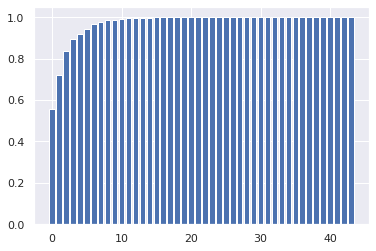

In [115]:
plt.bar(range(44), np.cumsum(pca.explained_variance_ratio_))

First 7 components describie 96,5% of the data. Should be enough.


What are they telling us about the data set? 

<BarContainer object of 44 artists>

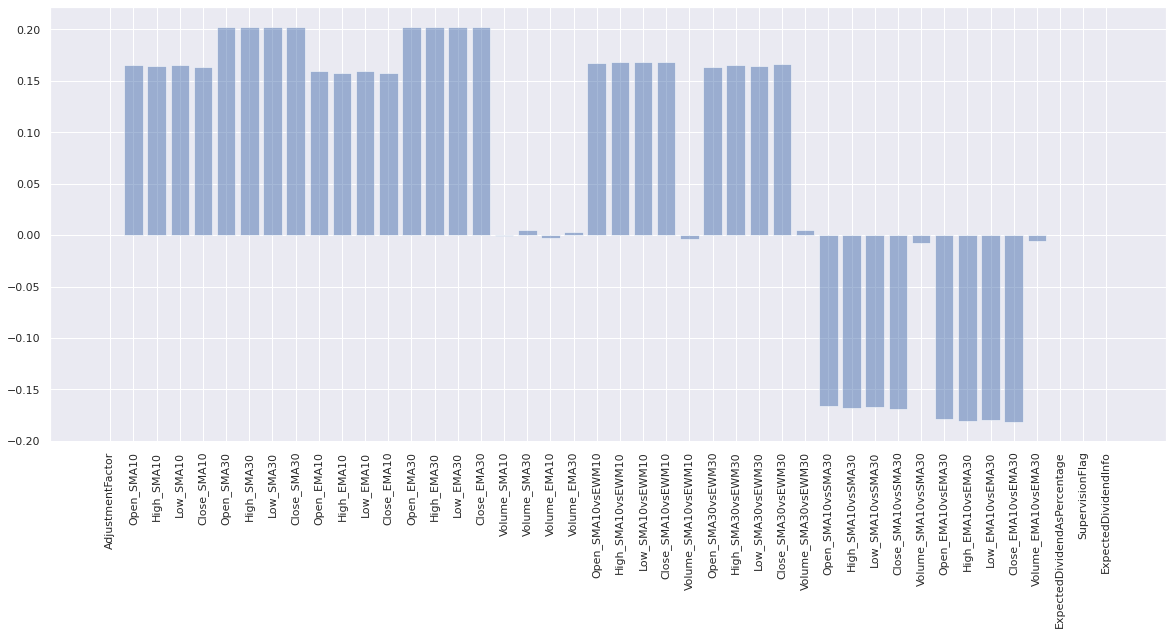

In [116]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[0, :], label='Pattern 0', alpha=0.5)

Pattern 0: All OHLC values comes in. This are highly correlated with each other, but ratio between short ma and long ma are negatively correlated. 

<BarContainer object of 44 artists>

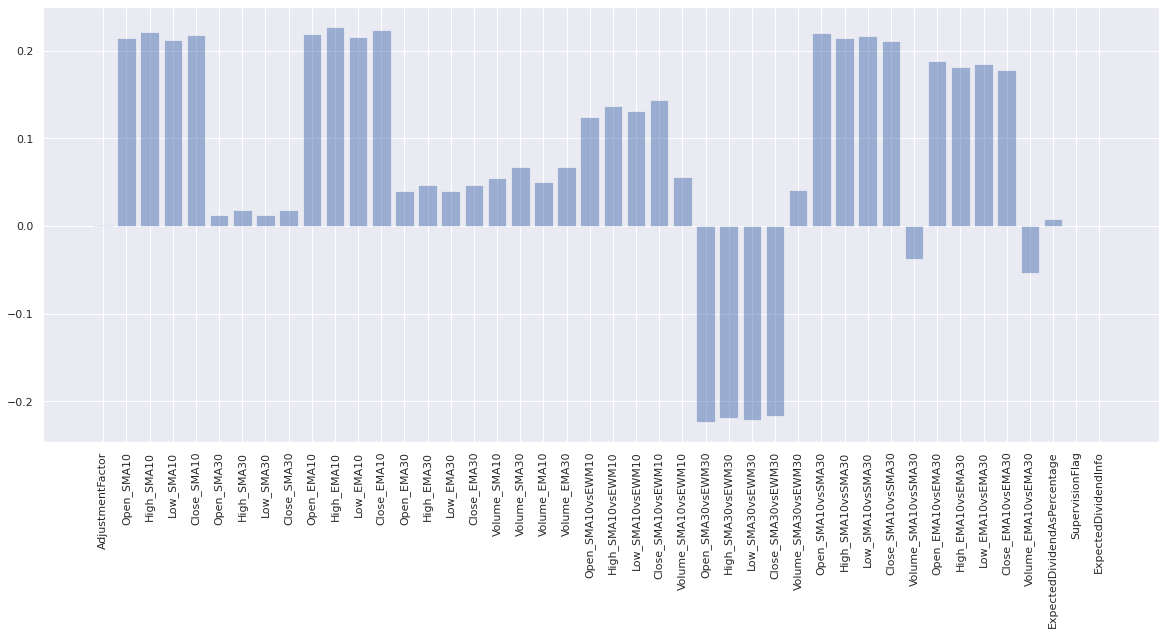

In [117]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[1, :], label='Pattern 1', alpha=0.5)

Pattern 1: Again OHLC values and relation beetwen them. But we have some volume as well..


<BarContainer object of 44 artists>

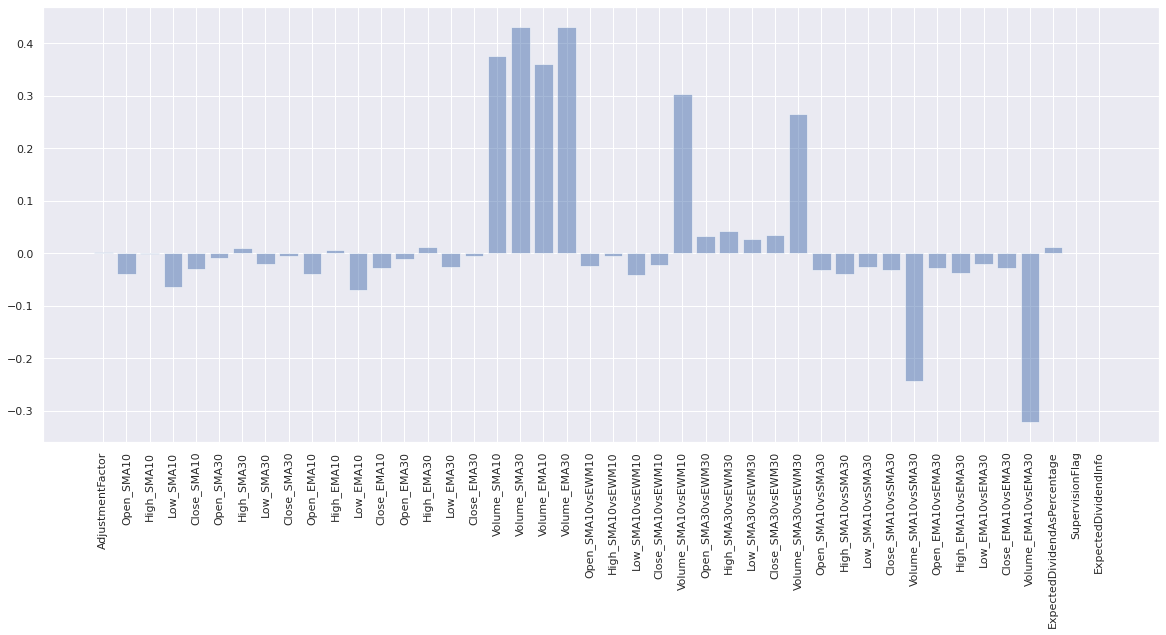

In [118]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[2, :], label='Pattern 2', alpha=0.5)

:Pattern 2: And this is where we can see how volume is important. 

<BarContainer object of 44 artists>

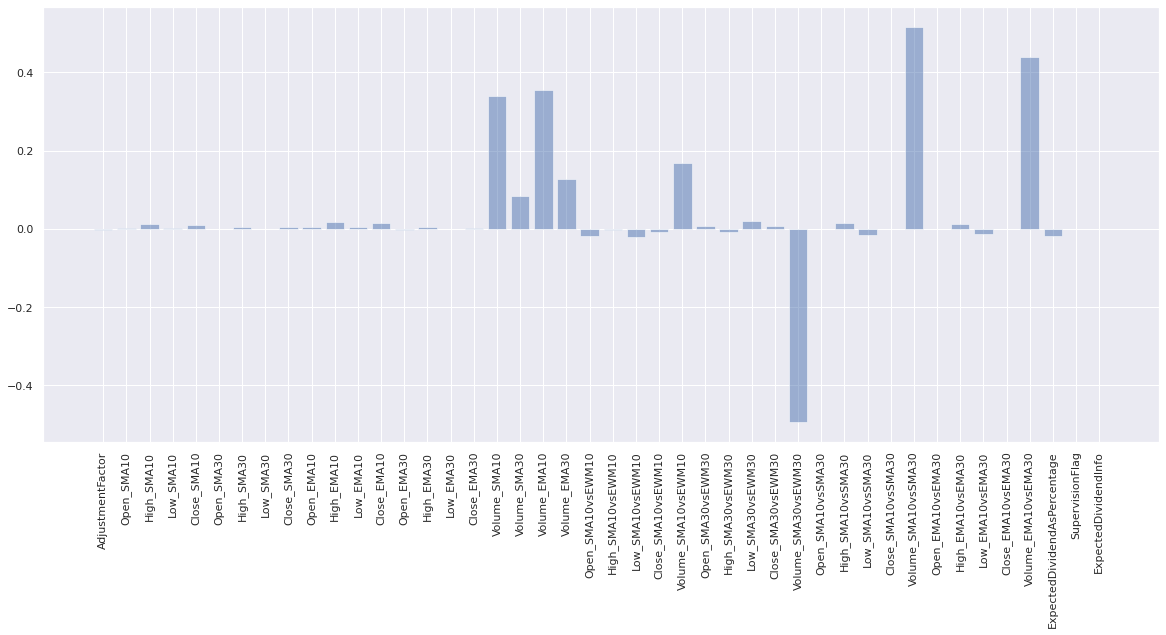

In [119]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[3, :], label='Pattern 3', alpha=0.5)

Pattern 3: More volume features are correlated with each other - both based on SMA and EMA. 

<BarContainer object of 44 artists>

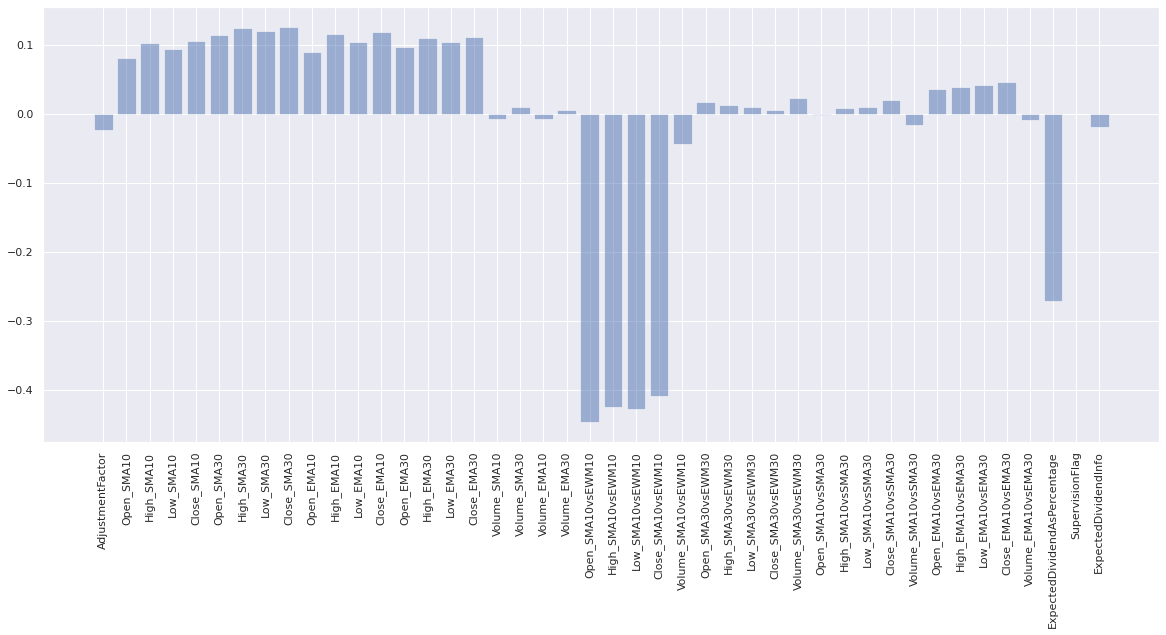

In [120]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[4, :], label='Pattern 4', alpha=0.5)

Pattern 4: Negative corelation between OHLC, but we see corelation with dividend as well.

<BarContainer object of 44 artists>

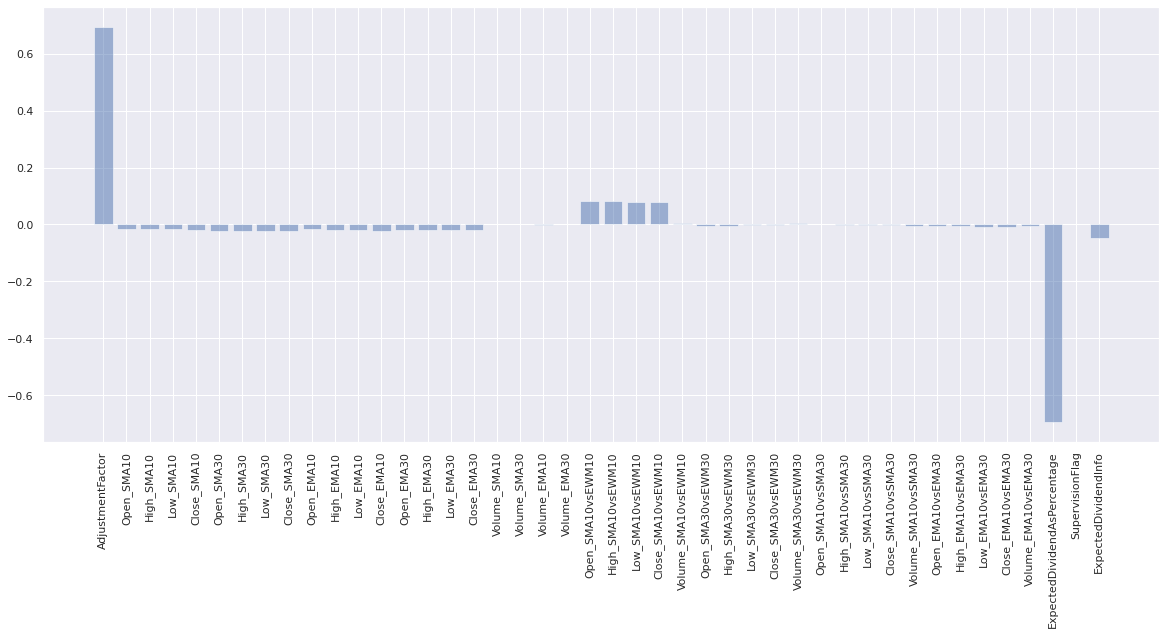

In [121]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[5, :], label='Pattern 5', alpha=0.5)

Pattern 5: Divident and Adjustiment factor are negativly correlated.

<BarContainer object of 44 artists>

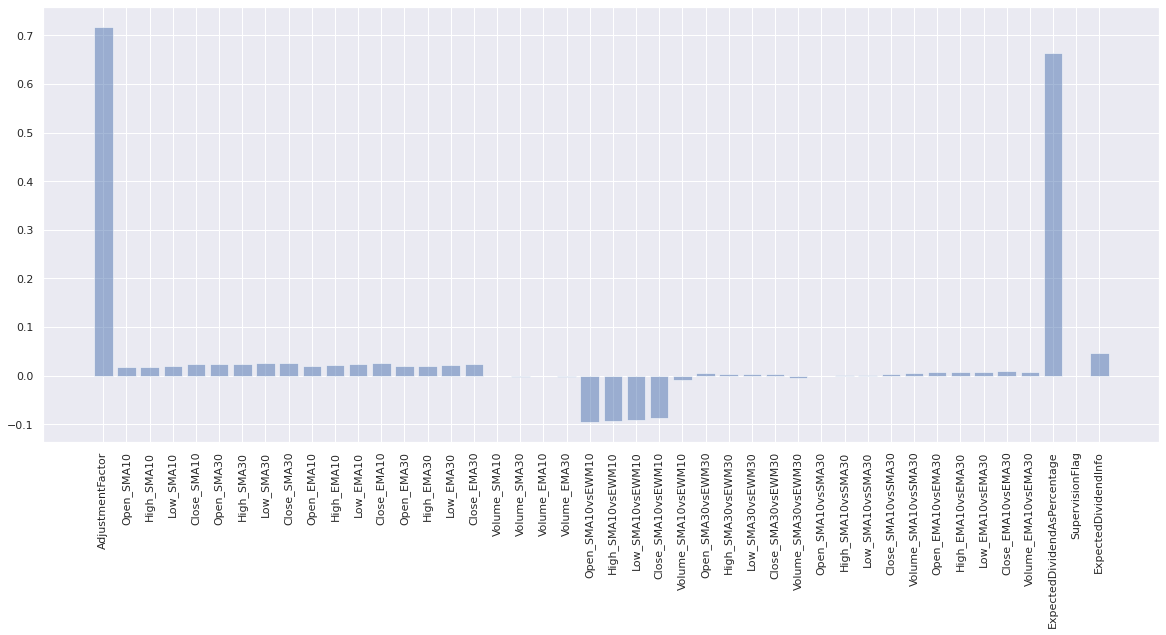

In [122]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(X_data.columns, pca.components_[6, :], label='Pattern 6', alpha=0.5)

Pattern 6: Divident and Adjustiment factor are positivly correlated as well (supplement information).

In [123]:
# I will take first five patterns into cosideration 
X_data = pca.transform(X_data)[:, :7]
X_data = pd.DataFrame(X_data) 

In [124]:
X_data.head()

,0,1,2,3,4,5,6
0,0.511436,-2.358701,3.116823,-2.194915,-1.220438,0.307000,-0.363877
1,2.583517,5.014054,19.606478,8.040207,0.159200,0.117660,-0.160134
2,0.413877,1.247650,-2.264139,1.535026,-0.543310,0.121686,-0.133657
3,1.600692,-1.005991,1.717725,-0.053551,-1.069300,0.254687,-0.301484
4,1.140675,0.199676,1.535144,-1.037174,-0.017318,0.069578,-0.087401


### 1.6 Housekeeping


In [125]:
del test_transformer, pca
del X_data, X_data_cols, y_data
del cat_data, cat_data_cols, column

## 2. Transformers
Starting to prepare transformers :) And a dataset to test it..

In [126]:
# copying datasets
X_data = X_train.copy()
y_data = y_train.copy()

### 2.1 ColumnsSelectorByType

In [127]:
class ColumnsSelectorByType(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns of specified types.
    """
    
    def __init__(self, column_type):
      self.column_type = column_type
            
    def fit(self, X, y=None):
      """
      Doing nothing..

      :param X: Dataset to work on
      :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
      :return: Fitted transformer.
      """      
      return self

    def transform(self, X):
      """
      Returning only columns according to pointed type.

      :param X: Dataset to work on
      :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
      :return: Input only with columns meeting given criteria.
      """

      return X.select_dtypes(include=self.column_type)

In [128]:
counter = 0
for column in X_data.columns:
  counter +=1
  print(counter, column, X_data[column].dtype)

1 AdjustmentFactor float64
2 SupervisionFlag category
3 Open_SMA10 float64
4 High_SMA10 float64
5 Low_SMA10 float64
6 Close_SMA10 float64
7 Open_SMA30 float64
8 High_SMA30 float64
9 Low_SMA30 float64
10 Close_SMA30 float64
11 Open_EMA10 float64
12 High_EMA10 float64
13 Low_EMA10 float64
14 Close_EMA10 float64
15 Open_EMA30 float64
16 High_EMA30 float64
17 Low_EMA30 float64
18 Close_EMA30 float64
19 Volume_SMA10 float64
20 Volume_SMA30 float64
21 Volume_EMA10 float64
22 Volume_EMA30 float64
23 Open_SMA10vsEWM10 float64
24 High_SMA10vsEWM10 float64
25 Low_SMA10vsEWM10 float64
26 Close_SMA10vsEWM10 float64
27 Volume_SMA10vsEWM10 float64
28 Open_SMA30vsEWM30 float64
29 High_SMA30vsEWM30 float64
30 Low_SMA30vsEWM30 float64
31 Close_SMA30vsEWM30 float64
32 Volume_SMA30vsEWM30 float64
33 Open_SMA10vsSMA30 float64
34 High_SMA10vsSMA30 float64
35 Low_SMA10vsSMA30 float64
36 Close_SMA10vsSMA30 float64
37 Volume_SMA10vsSMA30 float64
38 Open_EMA10vsEMA30 float64
39 High_EMA10vsEMA30 float64
40 Low

In [129]:
test_transformer = ColumnsSelectorByType(['category'])
categorical_data = test_transformer.fit_transform(X=X_data)
categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811938 entries, 2259226 to 914659
Data columns (total 2 columns):
 #   Column                Dtype   
---  ------                -----   
 0   SupervisionFlag       category
 1   ExpectedDividendInfo  category
dtypes: category(2)
memory usage: 81.8 MB


In [130]:
test_transformer = ColumnsSelectorByType([np.number])
numerical_data = test_transformer.fit_transform(X=X_data)
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811938 entries, 2259226 to 914659
Data columns (total 42 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   AdjustmentFactor              float64
 1   Open_SMA10                    float64
 2   High_SMA10                    float64
 3   Low_SMA10                     float64
 4   Close_SMA10                   float64
 5   Open_SMA30                    float64
 6   High_SMA30                    float64
 7   Low_SMA30                     float64
 8   Close_SMA30                   float64
 9   Open_EMA10                    float64
 10  High_EMA10                    float64
 11  Low_EMA10                     float64
 12  Close_EMA10                   float64
 13  Open_EMA30                    float64
 14  High_EMA30                    float64
 15  Low_EMA30                     float64
 16  Close_EMA30                   float64
 17  Volume_SMA10                  float64
 18  Volume_SMA30     

### 2.2 StandardScalerWrapper

In [131]:
class StandardScalerWrapper(BaseEstimator, TransformerMixin):
    """
    Wrapper for StandardScaler to return DataFrame.
    """   

    def __init__(self):    
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X,y)
        self.columns = X.columns
        return self

    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X),
                           columns = self.columns)

In [132]:
test_transformer = StandardScalerWrapper()
numerical_data = test_transformer.fit_transform(X=numerical_data)
numerical_data.head()

,AdjustmentFactor,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,Open_EMA10,...,High_SMA10vsSMA30,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendAsPercentage
0,-0.007569,-0.643387,-0.751194,-0.644842,-0.701232,0.036658,-0.028557,0.033260,-0.005029,-0.813357,...,-0.700489,-0.674260,-0.684071,-1.595431,-0.684058,-0.668143,-0.639018,-0.625560,-2.058172,-0.069953
1,-0.007569,-0.024707,1.930357,0.007517,1.562428,0.038108,1.023786,0.054115,0.844094,-0.171727,...,-0.062852,-0.007939,-0.110403,-0.936346,0.020762,-0.199841,-0.013673,-0.212589,-2.757169,-0.069953
2,-0.007569,0.419347,0.271492,0.532875,0.311432,0.029904,-0.037896,0.086787,-0.017348,0.450291,...,0.382280,0.286075,0.291911,1.284276,0.206270,0.265807,0.152972,0.191036,1.388579,-0.069953
3,-0.007569,0.282158,0.196274,-0.563192,-0.414636,0.427062,0.381962,-0.007109,0.063511,0.277540,...,-0.560804,-0.465524,-0.529537,-0.455875,-0.571418,-0.615173,-0.490450,-0.548043,-0.477612,-0.069953
4,-0.007569,0.222790,0.078632,0.223123,0.218677,0.199971,0.127730,0.201063,0.199516,0.247139,...,-0.175872,-0.173625,-0.179576,-0.783364,-0.239792,-0.221017,-0.210282,-0.228972,-1.211850,-0.069953


### 2.3 OrdinalEncoderWrapper

In [133]:
class OrdinalEncoderWrapper(BaseEstimator, TransformerMixin):
    """
    Wrapper for OrdinalEncoder to return DataFrame.
    """   

    def __init__(self):    
        self.encoder = OrdinalEncoder()
        
    def fit(self, X, y=None):
        self.encoder.fit(X,y)
        self.columns = X.columns
        return self

    def transform(self, X):
        return pd.DataFrame(self.encoder.transform(X),
                           columns = self.columns)

In [134]:
test_transformer = OrdinalEncoderWrapper()
categorical_data = test_transformer.fit_transform(X=categorical_data)

In [135]:
for column in categorical_data.columns:
  print(column, categorical_data[column].dtype, categorical_data[column].unique())

SupervisionFlag float64 [0. 1.]
ExpectedDividendInfo float64 [0. 1.]


### 2.4 PCAWrapper

In [136]:
class PCAWrapper(BaseEstimator, TransformerMixin):
    """
    Wrapper for PCA to return DataFrame.
    """   

    def __init__(self, n_components=None):
        self.pca = PCA(n_components)
        
    def fit(self, X, y=None):
        self.pca.fit(X,y)
        return self

    def transform(self, X):
        return pd.DataFrame(self.pca.transform(X))

In [137]:
X_data = numerical_data.join(categorical_data)

In [138]:
test_transformer = PCAWrapper(n_components=7)
X_data = test_transformer.fit_transform(X=X_data)
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811938 entries, 0 to 1811937
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
dtypes: float64(7)
memory usage: 96.8 MB


### 2.5 Housekeeping

In [139]:
del X_data, y_data, categorical_data, numerical_data
del test_transformer
del column, counter

## 3. Pipeline for preprocessing
And now building whole pipeline..

In [140]:
numerical_pipeline = Pipeline(steps=[ 
    ('choose_numerical_columns', ColumnsSelectorByType([np.number])),
    ('std_scaler', StandardScalerWrapper())
    ])

categorical_pipeline = Pipeline(steps=[             
    ('choose_numerical_columns', ColumnsSelectorByType(['category'])),
    ('encoding_categories', OrdinalEncoderWrapper())                       
    ])

preprocessing_pipeline = Pipeline(steps=[
    ('feature_union', FeatureUnion([ 
                                    ('numerical_pipeline', numerical_pipeline),
                                    ('categorical_pipeline', categorical_pipeline)
                                    ])),
    ('pca', PCAWrapper(n_components=7))                  
    ])

In [141]:
%%time
# dealing with train data - only X_train, y_train stays this same
preprocessing_pipeline = preprocessing_pipeline.fit(X=X_train)
X_train = preprocessing_pipeline.transform(X=X_train)
X_train.head()

CPU times: user 20.6 s, sys: 9.18 s, total: 29.7 s
Wall time: 17.6 s


,0,1,2,3,4,5,6
0,0.511436,-2.358701,3.116823,-2.194915,-1.220438,0.307000,-0.363877
1,2.583517,5.014054,19.606478,8.040207,0.159200,0.117660,-0.160134
2,0.413877,1.247650,-2.264139,1.535026,-0.543310,0.121686,-0.133657
3,1.600692,-1.005991,1.717725,-0.053551,-1.069300,0.254687,-0.301484
4,1.140675,0.199676,1.535144,-1.037174,-0.017318,0.069578,-0.087401


In [142]:
%%time
# dealing with test data - only X_test, y_test stays this same
X_test = preprocessing_pipeline.transform(X=X_test)
X_test.head()

CPU times: user 491 ms, sys: 311 ms, total: 803 ms
Wall time: 468 ms


,0,1,2,3,4,5,6
0,0.454668,-0.513064,-0.709274,-0.766136,-0.138582,0.075944,-0.088397
1,-3.630513,1.116210,-0.105192,-0.409247,0.452497,-0.025976,0.028321
2,4.338845,-2.459211,2.469156,0.675467,-1.222025,0.273009,-0.322780
3,-5.100007,0.183217,-1.768275,2.122763,0.740442,-0.125472,0.150062
4,-2.359104,-0.841784,-1.330064,0.477904,0.393338,-0.045550,0.054721


In [143]:
#housekeeping.. 
del categorical_pipeline, numerical_pipeline
del preprocessing_pipeline

## 4. Encoding labels of target column
Exacly!! It's about time to do labels encoding..

In [148]:
y_train.value_counts()

None    1062792
Long     749146
Name: Class, dtype: int64

In [149]:
y_train.head()

2259226    Long
726135     None
1952905    Long
1966128    Long
1659298    None
Name: Class, dtype: category
Categories (2, object): ['Long', 'None']

In [150]:
# dealing with train data - now it's time for y_train
le = LabelEncoder()
le = le.fit(y_train)
y_train = pd.Series(le.transform(y_train))
y_train.value_counts()

1    1062792
0     749146
dtype: int64

In [151]:
y_train.rename('Class', inplace=True)

0          0
1          1
2          0
3          0
4          1
          ..
1811933    1
1811934    0
1811935    0
1811936    1
1811937    1
Name: Class, Length: 1811938, dtype: int64

In [152]:
y_train.head()

0    0
1    1
2    0
3    0
4    1
Name: Class, dtype: int64

In [153]:
# dealing with test data - now it's time for y_train
y_test = pd.Series(le.transform(y_test))
y_test.value_counts()

1    265698
0    187287
dtype: int64

In [154]:
y_test.rename('Class', inplace=True)

0         1
1         1
2         0
3         1
4         1
         ..
452980    1
452981    0
452982    1
452983    1
452984    0
Name: Class, Length: 452985, dtype: int64

In [155]:
y_test.head()

0    1
1    1
2    0
3    1
4    1
Name: Class, dtype: int64

In [156]:
# housekeeping..
del le

Label 0 is our target - go Long !!

## 5. Savepoint
Yes, before we jump in modeling lets save data. 

In [159]:
# X_train 
with open ('X_train_after_preprocessing.pickle', 'wb') as f: 
  pickle.dump(X_train, f)

# y_train 
with open ('y_train_after_preprocessing.pickle', 'wb') as f: 
  pickle.dump(y_train, f)

# X_test
with open ('X_test_after_preprocessing.pickle', 'wb') as f: 
  pickle.dump(X_test, f)

# y_test 
with open ('y_test_after_preprocessing.pickle', 'wb') as f: 
  pickle.dump(y_test, f)

# I manually push this files to gdrive (don't want to authorize myself on gdrive in this code)

In [1]:
# # downloading files from gdrive
# !gdown 1jehXtlt8YX7i9eVRD4QFqDHe-M-i1MAw #X_train
# !gdown 1jd2OwijzGoZ5_s4Euxg6m-9DtpuzuhDS #y_train
# !gdown 13QS5eyq6VFpt3rbwWMc4jDmtVM9ehfpv #X_test
# !gdown 1OqCigssZg9beikQ9rAi9-CPWj0uLE4VN #y_test

Downloading...
From: https://drive.google.com/uc?id=1jehXtlt8YX7i9eVRD4QFqDHe-M-i1MAw
To: /content/X_train_after_preprocessing.pickle
100% 101M/101M [00:00<00:00, 241MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1jd2OwijzGoZ5_s4Euxg6m-9DtpuzuhDS
To: /content/y_train_after_preprocessing.pickle
100% 14.5M/14.5M [00:00<00:00, 187MB/s]
Downloading...
From: https://drive.google.com/uc?id=13QS5eyq6VFpt3rbwWMc4jDmtVM9ehfpv
To: /content/X_test_after_preprocessing.pickle
100% 25.4M/25.4M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OqCigssZg9beikQ9rAi9-CPWj0uLE4VN
To: /content/y_test_after_preprocessing.pickle
100% 3.62M/3.62M [00:00<00:00, 249MB/s]


In [2]:
# del X_test, y_test
# del X_train, y_train

In [6]:
# # X_train retrival
# with open('X_train_after_preprocessing.pickle', 'rb') as f:
#     X_train = pickle.load(f)

# # y_train retrival
# with open('y_train_after_preprocessing.pickle', 'rb') as f:
#     y_train = pickle.load(f)

# # X_test retrival
# with open('X_test_after_preprocessing.pickle', 'rb') as f:
#     X_test = pickle.load(f)

# # y_test retrival
# with open('y_test_after_preprocessing.pickle', 'rb') as f:
#     y_test = pickle.load(f) 

In [7]:
# housekeeping..
del f
# del STATUS_OK

# F. Modeling
At last we are in modeling phase!

Let's check what's under the hood? 

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep  5 05:13:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

.. and memory.. ? 

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Resampling
I'm resampling the dataset to make subsets to be even. 

Why now? 
- after PCA because I don't want resampling affect component analysis 
- before splitting dataset to train and test because I want both sets to be stratified similarly

In [10]:
# merge X and y
X_train = X_train.join(y_train)

In [11]:
# Let's check size of subsets 
X_train['Class'].value_counts()

1    1062792
0     749146
Name: Class, dtype: int64

Sets are not even - we need to resample. 

In [12]:
df_none = X_train[X_train['Class'] == 1]
df_long= X_train[X_train['Class'] == 0]

# Upsample
df_long_upsampled = resample(df_long, 
                             replace=True,
                             n_samples=1000000,
                             random_state=42)

In [13]:
# Combine majority class with upsampled minority classes
X_train = pd.concat([df_long_upsampled, df_none])

In [14]:
# # now it's better.. 
X_train['Class'].value_counts()

1    1062792
0    1000000
Name: Class, dtype: int64

In [15]:
y_train = X_train.pop(item='Class')

In [16]:
#housekeeping.. 
del df_long, df_long_upsampled, df_none

## 2. Building a model

We're going to try to implement few models (classifiers) on this data. Let it be: 

(more simple)

- Logistic Regression 
- K-Neighbors
- Decision Tree

(more complex)

- SVN
- Naive Bayes
- Random Forest
- XGBoost

As You can see we're not going to use Neural Network. 

In [17]:
# model listing - svn last to long, will try it separately

models = {
    'LogisticRegression':{
        'model': LogisticRegression()
    },
    'KNeighborsClassifier':{
        'model': KNeighborsClassifier()
    },
    'DecisionTreeClassifier':{
        'model': DecisionTreeClassifier()
    },
    # 'SVC':{
    #     'model': SVC()
    # },
    'GaussianNB':{
        'model': GaussianNB()
    },
    'RandomForestClassifier':{
        'model': RandomForestClassifier()
    },
    'XGBClassifier':{
        'model': XGBClassifier(tree_method='gpu_hist')
    }                        
}

### 2.1 First measurements
Let's try to fit all this models with base hyperparameters..

In [18]:
%%time
for model_name, model_params in models.items():
  print(f'model: {model_name}')
  
  # fit
  print(f'fitting..', end=' ')
  model = model_params['model']
  %time model.fit(X_train, y_train)
  
  #predict
  print(f'predicting..', end=' ')
  %time y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  
  #measure
  print(f'accuracy: {accuracy_score(y_test, y_pred)}')
  print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
  print(classification_report(y_pred, y_test))

model: LogisticRegression
fitting.. CPU times: user 6.04 s, sys: 9.73 s, total: 15.8 s
Wall time: 3.79 s
predicting.. CPU times: user 22.1 ms, sys: 64.7 ms, total: 86.9 ms
Wall time: 12.4 ms
accuracy: 0.5766084969700983
roc_auc: 0.5265885895107355
              precision    recall  f1-score   support

           0       0.19      0.47      0.27     75493
           1       0.85      0.60      0.70    377492

    accuracy                           0.58    452985
   macro avg       0.52      0.53      0.49    452985
weighted avg       0.74      0.58      0.63    452985

model: KNeighborsClassifier
fitting.. CPU times: user 8.66 s, sys: 76.9 ms, total: 8.74 s
Wall time: 8.57 s
predicting.. CPU times: user 1min 11s, sys: 1.89 s, total: 1min 13s
Wall time: 1min 11s
accuracy: 0.5348300716359261
roc_auc: 0.533813021211539
              precision    recall  f1-score   support

           0       0.46      0.44      0.45    196812
           1       0.59      0.61      0.60    256173

    accur

In [19]:
# %%time
# print(f'model: SVN')

# # fit
# print(f'fitting..', end=' ')
# model = SVC()
# %time model.fit(X_train, y_train)

# #predict
# print(f'predicting..', end=' ')
# %time y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]

# #measure
# print(f'accuracy: {accuracy_score(y_test, y_pred)}')
# print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
# print(classification_report(y_pred, y_test))

SVN is taking really long time to compute.. 

It's not the worst place to start :) As we can see KNN and XGBoost are good direction for us.  

**Conclusions:** In next steps we are going to use XGBoost. It has almost best results and short calculation time. 

### 2.2 Finding right hyperparameters
What's the plan? 

- first step is to check which booster should be used.. 
- after that we will try to start with low tree number and high learning rate.. 
- then we will search for other params .. 
- on the end we will try to lower learning rate..

First step is to check which booster should be used.. 

In [20]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree', 'gblinear', 'dart']}

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'tree_method': 'gpu_hist'}
Best DC accuracy 0.568209493919188
Test accuracy of best grid search hypers: 0.5865911674779518
CPU times: user 23min 19s, sys: 1.99 s, total: 23min 21s
Wall time: 23min 13s


Now we know - we stick to trees.. (its cool because we have GPU onboard).

Let's set up tree number (low) and learning rate (high).



In [21]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree'],
              'n_estimators': [3,5,8,16,30,60],
              'learning_rate': [0.1, 0.2, 0.3]
              }

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'learning_rate': 0.3, 'n_estimators': 60, 'tree_method': 'gpu_hist'}
Best DC accuracy 0.5690903390353583
Test accuracy of best grid search hypers: 0.585352715873594
CPU times: user 47.8 s, sys: 3.82 s, total: 51.7 s
Wall time: 51.1 s


In [22]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree'],
              'n_estimators': [30,60, 80, 100, 120, 140],
              'learning_rate': [0.1, 0.3, 0.5, 0.7]
              }

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'learning_rate': 0.5, 'n_estimators': 140, 'tree_method': 'gpu_hist'}
Best DC accuracy 0.5709257157121036
Test accuracy of best grid search hypers: 0.5842732099296887
CPU times: user 1min 41s, sys: 5.12 s, total: 1min 46s
Wall time: 1min 45s


In [23]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree'],
              'n_estimators': [30, 100, 120, 140, 160, 180, 200],
              'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7]
              }

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'learning_rate': 0.5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
Best DC accuracy 0.5713673502703457
Test accuracy of best grid search hypers: 0.5847390090179586
CPU times: user 3min 2s, sys: 7.65 s, total: 3min 10s
Wall time: 3min 8s


For now lets stick to:

- low number of trees - it's not a big difference when we use for example 60 or 200 estimators
- big learning rate - 0.5 is ok

We will check other parameters and theh we will go back to those two..

In [24]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree'],
              'n_estimators': [60],
              'learning_rate': [0.5],
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [0.5, 0.6, 0.7],
              'gamma': [0, 0.1, 0.2, 0.3, 0.4]  
              }

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'gamma': 0.4, 'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 0.6, 'n_estimators': 60, 'tree_method': 'gpu_hist'}
Best DC accuracy 0.5753832669156669
Test accuracy of best grid search hypers: 0.5830811174762961
CPU times: user 4min 39s, sys: 13.7 s, total: 4min 53s
Wall time: 4min 50s


We have our setup. Now lets increase estimators number and lower learning rate..

In [25]:
%%time
xb = XGBClassifier()

parameters = {'tree_method':['gpu_hist'],
              'booster':['gbtree'],
              'n_estimators': [1150, 1200, 1250],
              'learning_rate': [0.02, 0.03, 0.04],
              'max_depth': [5],
              'min_child_weight': [0.6],
              'gamma': [0.3]  
              }

searcher = GridSearchCV(xb, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best DC params", searcher.best_params_)
print("Best DC accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best DC params {'booster': 'gbtree', 'gamma': 0.3, 'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 0.6, 'n_estimators': 1250, 'tree_method': 'gpu_hist'}
Best DC accuracy 0.5744607304485854
Test accuracy of best grid search hypers: 0.5864167687671777
CPU times: user 6min 31s, sys: 2.93 s, total: 6min 34s
Wall time: 6min 31s


We have our setup !

We have our setup, let's check it..

In [26]:
%%time
print(f'model: XGBClassifier')

# fit
print(f'fitting..', end=' ')
model =  XGBClassifier(booster='gbtree', 
                       gamma=0.3, 
                       learning_rate=0.03, 
                       max_depth=5, 
                       min_child_weight=0.6, 
                       n_estimators=1200, 
                       tree_method='gpu_hist'
                       )
%time model.fit(X_train, y_train)

#predict
print(f'predicting..', end=' ')
%time y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

#measure
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'roc_auc: {roc_auc_score(y_test, y_pred_proba)}')
print(classification_report(y_pred, y_test))

model: XGBClassifier
fitting.. CPU times: user 9.36 s, sys: 54 ms, total: 9.41 s
Wall time: 9.36 s
predicting.. CPU times: user 109 ms, sys: 3 ms, total: 112 ms
Wall time: 110 ms
accuracy: 0.5863218428866298
roc_auc: 0.5990772954690027
              precision    recall  f1-score   support

           0       0.46      0.50      0.48    172029
           1       0.68      0.64      0.66    280956

    accuracy                           0.59    452985
   macro avg       0.57      0.57      0.57    452985
weighted avg       0.59      0.59      0.59    452985

CPU times: user 10.5 s, sys: 73 ms, total: 10.6 s
Wall time: 10.5 s


Well this is terrible results for class 0.. 

Checking overfitting .. 

In [27]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d

def calculating_metrics(X_train, X_test, y_train, y_test):
    train = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    test = create_measures(y_test,model.predict_proba(X_test)[:, 1])
    # val = create_measures(y_val,model.predict_proba(X_val)[:, 1]) 

    measures =  pd.concat([train,test]).set_index([pd.Index(['TRAIN', 'TEST'])]) 
    
    return measures

In [28]:
measures = calculating_metrics(X_train, X_test, y_train, y_test)
measures

,AUC,GINI
TRAIN,0.6103,0.2206
TEST,0.5991,0.1982


Model is not overfitted. 

### 2.3 Savepoint

In [29]:
# saving model
with open ('XGBoost_model.pickle', 'wb') as f: 
  pickle.dump(model, f)

In [30]:
# !gdown 1-jNb9WMBoM39VTn1f_LqQG95L59IK4Wo #model

In [31]:
# model retrival
# with open('XGBoost_model.pickle', 'rb') as f:
#     model = pickle.load(f)

### 2.4 Treshold
We have our model. Now we will look after higher confidence. It's so important when you want to put your money on the market. 

In other words we need high precision (for class 0 - Long).

In [32]:
# swapping Long to be class 1 
y_pred_proba_swap = 1-y_pred_proba
y_pred_proba_swap

array([0.33724672, 0.5363722 , 0.64102453, ..., 0.41981828, 0.45640516,
       0.5162269 ], dtype=float32)

In [33]:
y_test_swap = np.where(y_test==0, 1, 0)
y_test_swap 

array([0, 0, 1, ..., 0, 0, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

    threshold  precision    recall        F1
36       0.36   0.424793  0.955341  0.588091
    threshold  precision    recall        F1
95       0.95        1.0  0.000016  0.000032


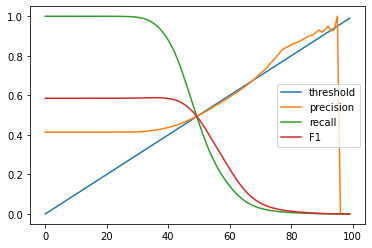

In [34]:
def get_metrics(y_true,  y_pred_proba, thresholds = None):
    if thresholds is None:
        thresholds = np.arange(0, 1, 0.01)
    precision, recall, f1 = [], [], []
    
    for t in thresholds:
        preds = (y_pred_proba>t)
        precision.append(precision_score(y_true, preds))
        recall.append(recall_score(y_true, preds))
        f1.append(f1_score(y_true, preds))
        
    return pd.DataFrame({
        'threshold': thresholds,
        'precision': precision,
        'recall': recall,
        'F1': f1
    })
    
    
metrics = get_metrics(y_test_swap, y_pred_proba_swap)
metrics.plot()

print(metrics[metrics['F1']==metrics['F1'].max()])
print(metrics[metrics['precision']==metrics['precision'].max()])

We swap classes and I will describe situation like that. 
- if we set treshhold to 0.36 then our precision will be near 0.4 with  a lot of true cases (recall = 0.95)
- if we set treshold to 0.93 then our precision will go up to 1.00! But there will be low number of true cases (near 0)
- maybe we should find sth between :) 

Best we can do is precision near 0.5 and recall near 0.5.

In [56]:
print(classification_report(y_test_swap, y_pred_proba_swap>0.5))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66    265698
           1       0.50      0.46      0.48    187287

    accuracy                           0.59    452985
   macro avg       0.57      0.57      0.57    452985
weighted avg       0.58      0.59      0.58    452985



In [57]:
# unswapping 
y_pred_unswap = y_pred_proba_swap > 0.5
y_pred_unswap = np.where(y_pred_unswap==False, True, False)

In [58]:
# classification report (Long is class 0 again)
print(classification_report(y_test, y_pred_unswap))

              precision    recall  f1-score   support

           0       0.50      0.46      0.48    187287
           1       0.64      0.68      0.66    265698

    accuracy                           0.59    452985
   macro avg       0.57      0.57      0.57    452985
weighted avg       0.58      0.59      0.58    452985



# G. Summary and discussion

As we can see it's not an easy task to build good model for jpx trading. Dataset is quite big and methods we chose do not give expected results. Anyway effects are really bad! 

## Are we able to compute a better model? 
Well, I think yes. But it is not a simple task. 

Maybe SVN would perform (it took to long to compute) or how few ensembled SVNs would perform better?

If not then there is still deep learning path :)

## What else can we do? 
For modeling purposes we develop few features. We can do better in this area as well. There's a lot to add:
- OHLCV data from previous periods (now we have only means)
- OHLCV data for highier time interval
- information about trend and trend angles
- candelstick patterns
- widely used indicators like MACD, OBV, Stochastic
- zigzags 
- waves 
- and many others.. 

Doing so we will highlight other aspects of explanatory variables we have. 

## Make requirements / goal more accurate to data?
Last but not least - it is important to have right expectations about data.  Maybe we should expect less accurate results or change our target?

We can just change way we calculate class column to give our attempt more chances to achive. Ofcourse not in all situations we can do that. Now we can and we did :) 